# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    celeb_data = datasets.ImageFolder(data_dir, transform) 
    data_loader = torch.utils.data.DataLoader(celeb_data, batch_size=batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

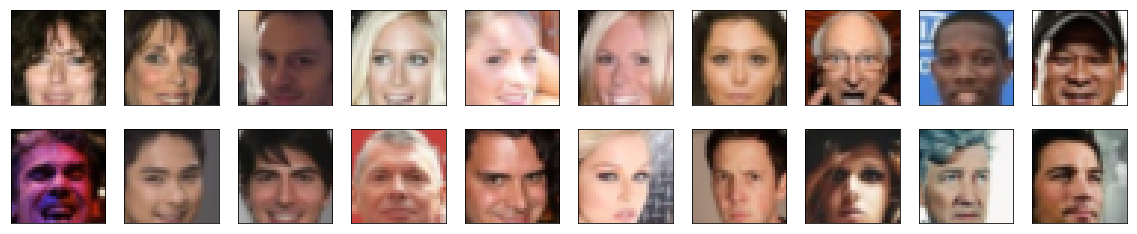

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min_r, max_r = feature_range
    x = x*(max_r - min_r)  + min_r
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.9686)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # Input of 32x32
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)  # Too much? Good or bad?
        # 2x2
        
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = self.dropout(out)
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.fc(out) # For some reason we end with a 50x1x1x1 tensor...
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        # The first transpose conv layer should have a 4x4 size and depth of 512 = (4*32)
        self.fc = nn.Linear(z_size, conv_dim*4*4*4) 
        # The output of fc will be reshaped into a 4*4*512 vector
        # 4x4
        self.tconv1 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, stride=2, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(conv_dim*2)
        # 8x8
        self.tconv2 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(conv_dim)
        # 16x6
        self.tconv3 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1, bias=False)
        # 32x32
        
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        # reshaping the vector to (batchsize, conv depth, 4size, 4size)
        out = out.view(-1, self.conv_dim*4, 4, 4) 
        
        out = F.relu(self.norm1(self.tconv1(out)))
        out = self.dropout(out)
        out = F.relu(self.norm2(self.tconv2(out)))
        out = self.dropout(out)
        out = self.tconv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

E:\dev\venv\deeplearnudacity\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (tconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
import random

def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    # Adding smoothing
    labels = torch.ones(D_out.size(0)) * random.uniform(0.8, 1.1)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    # labels = torch.zeros(D_out.size(0))
    labels = torch.ones(D_out.size(0)) * random.uniform(0, 0.3)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1 = 0.3
beta2 = 0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def view_sample(sample):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), sample):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            # 1.1 Real images train
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            
            d_real_loss = real_loss(D_real)
            
            # 1.2 Fake images
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            
            D_fake = D(fake_images)
            
            # compute the fake loss
            d_fake_loss = fake_loss(D_fake)
            
            # final discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # 2.1 Train with
            # Generate fake img
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            D_fake = D(fake_images)
            
            # compute generator loss on fake img
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
                
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
            


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
        # View the sample on runtime
        _ = view_sample(samples_z)
        
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/   50] | d_loss: 1.3910 | g_loss: 0.6682
Epoch [    1/   50] | d_loss: 0.8569 | g_loss: 1.4019
Epoch [    1/   50] | d_loss: 0.6027 | g_loss: 1.6790
Epoch [    1/   50] | d_loss: 0.7230 | g_loss: 1.3958
Epoch [    1/   50] | d_loss: 0.7067 | g_loss: 1.9906
Epoch [    1/   50] | d_loss: 0.5746 | g_loss: 1.2110
Epoch [    1/   50] | d_loss: 0.8296 | g_loss: 1.1086
Epoch [    1/   50] | d_loss: 1.1765 | g_loss: 2.2454
Epoch [    1/   50] | d_loss: 0.5215 | g_loss: 2.1520
Epoch [    1/   50] | d_loss: 0.4735 | g_loss: 1.2991
Epoch [    1/   50] | d_loss: 0.8114 | g_loss: 2.4618
Epoch [    1/   50] | d_loss: 1.1910 | g_loss: 1.1255
Epoch [    1/   50] | d_loss: 0.5493 | g_loss: 1.9982
Epoch [    1/   50] | d_loss: 0.8755 | g_loss: 1.2974
Epoch [    1/   50] | d_loss: 0.9802 | g_loss: 1.2211
Epoch [    1/   50] | d_loss: 0.6416 | g_loss: 0.8920
Epoch [    1/   50] | d_loss: 1.1366 | g_loss: 1.0438
Epoch [    1/   50] | d_loss: 1.1124 | g_loss: 1.5520
Epoch [    1/   50] | d_loss

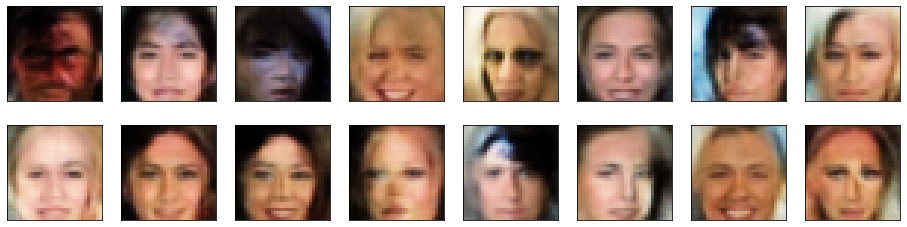

Epoch [    2/   50] | d_loss: 1.3033 | g_loss: 1.1863
Epoch [    2/   50] | d_loss: 0.8353 | g_loss: 0.7724
Epoch [    2/   50] | d_loss: 0.9119 | g_loss: 0.5557
Epoch [    2/   50] | d_loss: 1.3007 | g_loss: 1.2457
Epoch [    2/   50] | d_loss: 0.8795 | g_loss: 1.9697
Epoch [    2/   50] | d_loss: 0.6681 | g_loss: 1.4781
Epoch [    2/   50] | d_loss: 0.9823 | g_loss: 1.8314
Epoch [    2/   50] | d_loss: 1.0710 | g_loss: 1.3701
Epoch [    2/   50] | d_loss: 1.1787 | g_loss: 1.9422
Epoch [    2/   50] | d_loss: 0.8102 | g_loss: 1.9080
Epoch [    2/   50] | d_loss: 0.7438 | g_loss: 1.0242
Epoch [    2/   50] | d_loss: 1.1588 | g_loss: 1.7824
Epoch [    2/   50] | d_loss: 1.3057 | g_loss: 1.0499
Epoch [    2/   50] | d_loss: 0.9634 | g_loss: 1.2772
Epoch [    2/   50] | d_loss: 0.9154 | g_loss: 0.9210
Epoch [    2/   50] | d_loss: 1.1835 | g_loss: 0.9239
Epoch [    2/   50] | d_loss: 0.8827 | g_loss: 1.0298
Epoch [    2/   50] | d_loss: 1.1743 | g_loss: 0.7416
Epoch [    2/   50] | d_loss

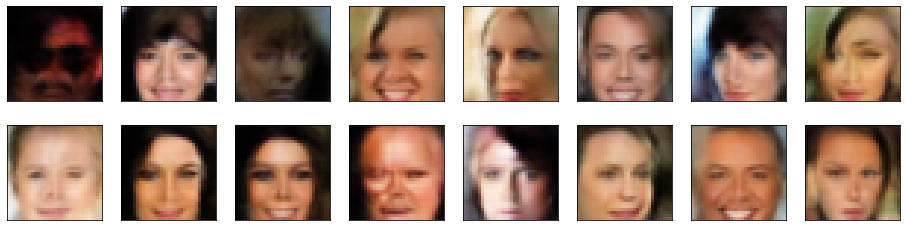

Epoch [    3/   50] | d_loss: 1.7239 | g_loss: 1.2022
Epoch [    3/   50] | d_loss: 0.8292 | g_loss: 1.2497
Epoch [    3/   50] | d_loss: 1.2133 | g_loss: 0.5968
Epoch [    3/   50] | d_loss: 1.1637 | g_loss: 1.6309
Epoch [    3/   50] | d_loss: 0.6632 | g_loss: 0.7363
Epoch [    3/   50] | d_loss: 0.9612 | g_loss: 1.9224
Epoch [    3/   50] | d_loss: 1.0649 | g_loss: 1.2571
Epoch [    3/   50] | d_loss: 0.6731 | g_loss: 1.7865
Epoch [    3/   50] | d_loss: 0.6929 | g_loss: 0.6749
Epoch [    3/   50] | d_loss: 1.0290 | g_loss: 1.1276
Epoch [    3/   50] | d_loss: 0.9251 | g_loss: 1.0318
Epoch [    3/   50] | d_loss: 1.1993 | g_loss: 1.4938
Epoch [    3/   50] | d_loss: 1.1642 | g_loss: 0.5291
Epoch [    3/   50] | d_loss: 1.1142 | g_loss: 0.6794
Epoch [    3/   50] | d_loss: 1.0474 | g_loss: 1.3300
Epoch [    3/   50] | d_loss: 0.9933 | g_loss: 2.0805
Epoch [    3/   50] | d_loss: 0.9802 | g_loss: 1.0539
Epoch [    3/   50] | d_loss: 0.9230 | g_loss: 2.3488
Epoch [    3/   50] | d_loss

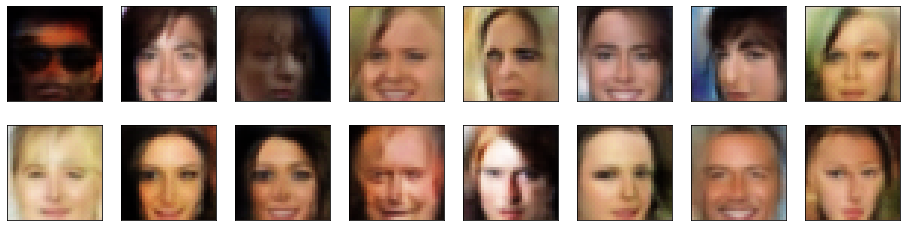

Epoch [    4/   50] | d_loss: 1.1997 | g_loss: 3.3540
Epoch [    4/   50] | d_loss: 1.3718 | g_loss: 0.9826
Epoch [    4/   50] | d_loss: 1.1967 | g_loss: 2.0537
Epoch [    4/   50] | d_loss: 0.5815 | g_loss: 2.6740
Epoch [    4/   50] | d_loss: 0.8053 | g_loss: 1.1959
Epoch [    4/   50] | d_loss: 0.8525 | g_loss: 1.8422
Epoch [    4/   50] | d_loss: 1.0196 | g_loss: 1.9673
Epoch [    4/   50] | d_loss: 0.8329 | g_loss: 2.7682
Epoch [    4/   50] | d_loss: 1.0322 | g_loss: 1.2327
Epoch [    4/   50] | d_loss: 0.5330 | g_loss: 1.7881
Epoch [    4/   50] | d_loss: 0.6022 | g_loss: 0.7822
Epoch [    4/   50] | d_loss: 0.7062 | g_loss: 2.5222
Epoch [    4/   50] | d_loss: 1.1046 | g_loss: 2.1699
Epoch [    4/   50] | d_loss: 0.6460 | g_loss: 0.6206
Epoch [    4/   50] | d_loss: 0.6610 | g_loss: 0.8792
Epoch [    4/   50] | d_loss: 1.0678 | g_loss: 1.2328
Epoch [    4/   50] | d_loss: 2.1099 | g_loss: 0.5471
Epoch [    4/   50] | d_loss: 1.2319 | g_loss: 2.2545
Epoch [    4/   50] | d_loss

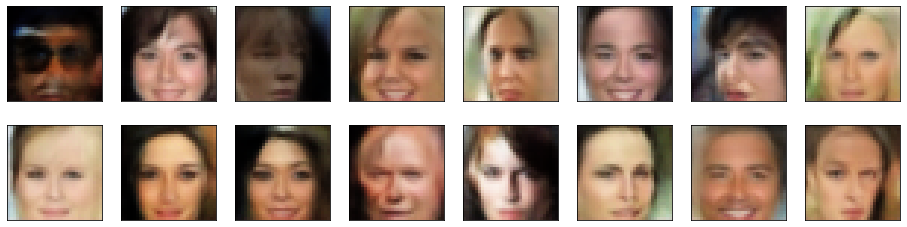

Epoch [    5/   50] | d_loss: 0.8994 | g_loss: 1.8314
Epoch [    5/   50] | d_loss: 0.6510 | g_loss: 1.0582
Epoch [    5/   50] | d_loss: 0.5626 | g_loss: 1.8550
Epoch [    5/   50] | d_loss: 0.9557 | g_loss: 1.6998
Epoch [    5/   50] | d_loss: 0.6794 | g_loss: 1.1680
Epoch [    5/   50] | d_loss: 1.1250 | g_loss: 2.1937
Epoch [    5/   50] | d_loss: 0.5995 | g_loss: 1.5412
Epoch [    5/   50] | d_loss: 0.9334 | g_loss: 2.1502
Epoch [    5/   50] | d_loss: 0.7621 | g_loss: 0.5558
Epoch [    5/   50] | d_loss: 0.3789 | g_loss: 1.3674
Epoch [    5/   50] | d_loss: 0.7644 | g_loss: 2.2209
Epoch [    5/   50] | d_loss: 0.8087 | g_loss: 3.3533
Epoch [    5/   50] | d_loss: 0.4724 | g_loss: 0.3865
Epoch [    5/   50] | d_loss: 0.6116 | g_loss: 0.7701
Epoch [    5/   50] | d_loss: 0.9103 | g_loss: 1.3504
Epoch [    5/   50] | d_loss: 0.5260 | g_loss: 2.4179
Epoch [    5/   50] | d_loss: 0.7530 | g_loss: 1.4092
Epoch [    5/   50] | d_loss: 1.2570 | g_loss: 1.2657
Epoch [    5/   50] | d_loss

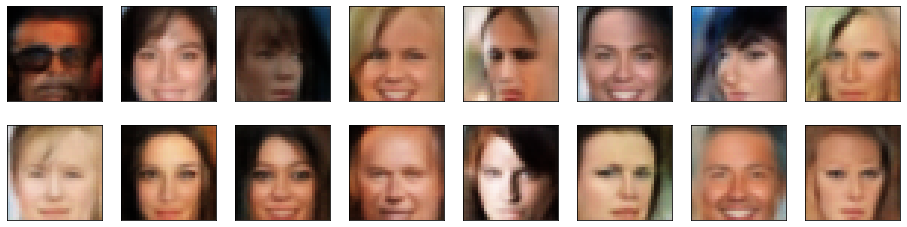

Epoch [    6/   50] | d_loss: 1.3756 | g_loss: 2.8852
Epoch [    6/   50] | d_loss: 1.0747 | g_loss: 1.8188
Epoch [    6/   50] | d_loss: 0.4814 | g_loss: 1.1050
Epoch [    6/   50] | d_loss: 1.2859 | g_loss: 2.9688
Epoch [    6/   50] | d_loss: 1.2904 | g_loss: 0.5939
Epoch [    6/   50] | d_loss: 1.0810 | g_loss: 2.6651
Epoch [    6/   50] | d_loss: 0.4761 | g_loss: 0.9705
Epoch [    6/   50] | d_loss: 1.2096 | g_loss: 1.1633
Epoch [    6/   50] | d_loss: 0.4758 | g_loss: 0.9290
Epoch [    6/   50] | d_loss: 0.8225 | g_loss: 0.9283
Epoch [    6/   50] | d_loss: 0.9942 | g_loss: 1.8394
Epoch [    6/   50] | d_loss: 0.6827 | g_loss: 2.0495
Epoch [    6/   50] | d_loss: 0.5582 | g_loss: 1.5910
Epoch [    6/   50] | d_loss: 0.3567 | g_loss: 0.4116
Epoch [    6/   50] | d_loss: 0.9414 | g_loss: 1.5574
Epoch [    6/   50] | d_loss: 0.2216 | g_loss: 1.8638
Epoch [    6/   50] | d_loss: 0.2317 | g_loss: 0.9232
Epoch [    6/   50] | d_loss: 1.0925 | g_loss: 1.3346
Epoch [    6/   50] | d_loss

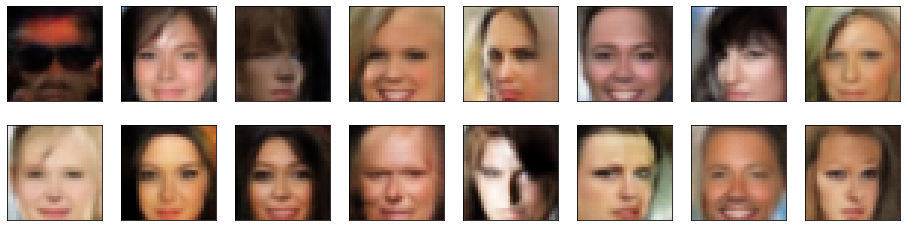

Epoch [    7/   50] | d_loss: 0.4680 | g_loss: 2.1831
Epoch [    7/   50] | d_loss: 0.6906 | g_loss: 2.4666
Epoch [    7/   50] | d_loss: 0.1518 | g_loss: 2.8763
Epoch [    7/   50] | d_loss: 0.8099 | g_loss: 1.4152
Epoch [    7/   50] | d_loss: 0.4472 | g_loss: 2.2550
Epoch [    7/   50] | d_loss: 0.3900 | g_loss: 1.1799
Epoch [    7/   50] | d_loss: 1.0050 | g_loss: 1.5926
Epoch [    7/   50] | d_loss: 1.0520 | g_loss: 2.6351
Epoch [    7/   50] | d_loss: 0.9898 | g_loss: 1.1270
Epoch [    7/   50] | d_loss: 0.6666 | g_loss: 1.6360
Epoch [    7/   50] | d_loss: 0.6470 | g_loss: 1.5186
Epoch [    7/   50] | d_loss: 1.3990 | g_loss: 1.6951
Epoch [    7/   50] | d_loss: 1.1487 | g_loss: 1.5157
Epoch [    7/   50] | d_loss: 0.7831 | g_loss: 1.3830
Epoch [    7/   50] | d_loss: 1.1386 | g_loss: 0.8177
Epoch [    7/   50] | d_loss: 0.9162 | g_loss: 0.9533
Epoch [    7/   50] | d_loss: 1.0566 | g_loss: 1.9915
Epoch [    7/   50] | d_loss: 0.9773 | g_loss: 2.3368
Epoch [    7/   50] | d_loss

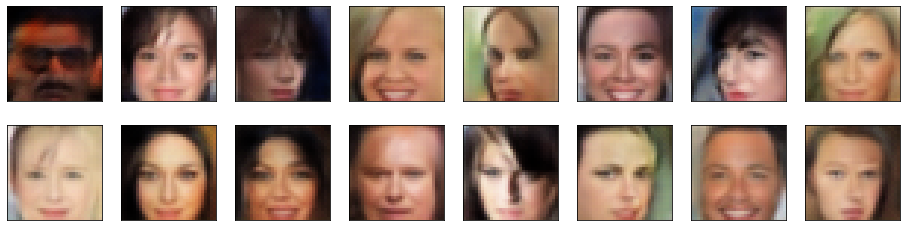

Epoch [    8/   50] | d_loss: 0.8172 | g_loss: 0.9438
Epoch [    8/   50] | d_loss: 0.9085 | g_loss: 1.6807
Epoch [    8/   50] | d_loss: 0.9999 | g_loss: 0.6795
Epoch [    8/   50] | d_loss: 0.8918 | g_loss: 1.2580
Epoch [    8/   50] | d_loss: 0.1391 | g_loss: 1.8009
Epoch [    8/   50] | d_loss: 0.4515 | g_loss: 1.2267
Epoch [    8/   50] | d_loss: 0.7379 | g_loss: 0.9256
Epoch [    8/   50] | d_loss: 0.4976 | g_loss: 0.5816
Epoch [    8/   50] | d_loss: 0.3388 | g_loss: 1.8206
Epoch [    8/   50] | d_loss: 0.8485 | g_loss: 1.8461
Epoch [    8/   50] | d_loss: 1.0222 | g_loss: 1.5019
Epoch [    8/   50] | d_loss: 1.5273 | g_loss: 2.1307
Epoch [    8/   50] | d_loss: 0.4115 | g_loss: 1.0380
Epoch [    8/   50] | d_loss: 0.8717 | g_loss: 1.3643
Epoch [    8/   50] | d_loss: 0.8237 | g_loss: 1.8755
Epoch [    8/   50] | d_loss: 1.1063 | g_loss: 0.1646
Epoch [    8/   50] | d_loss: 1.2104 | g_loss: 2.2162
Epoch [    8/   50] | d_loss: 0.7047 | g_loss: 2.6424
Epoch [    8/   50] | d_loss

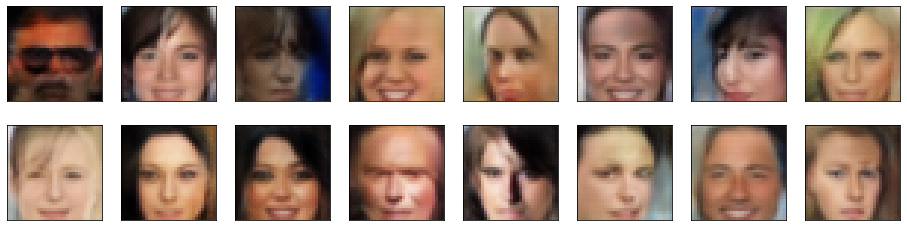

Epoch [    9/   50] | d_loss: 0.6447 | g_loss: 1.8517
Epoch [    9/   50] | d_loss: 0.9823 | g_loss: 1.9341
Epoch [    9/   50] | d_loss: 1.0199 | g_loss: 0.9286
Epoch [    9/   50] | d_loss: 0.7331 | g_loss: 1.8157
Epoch [    9/   50] | d_loss: 0.6263 | g_loss: 1.5274
Epoch [    9/   50] | d_loss: 0.7990 | g_loss: 2.0446
Epoch [    9/   50] | d_loss: 0.8450 | g_loss: 2.0144
Epoch [    9/   50] | d_loss: 0.7030 | g_loss: 1.1301
Epoch [    9/   50] | d_loss: 0.5949 | g_loss: 0.6510
Epoch [    9/   50] | d_loss: 0.8372 | g_loss: 1.8053
Epoch [    9/   50] | d_loss: 0.9281 | g_loss: 1.6980
Epoch [    9/   50] | d_loss: 0.3094 | g_loss: 1.8615
Epoch [    9/   50] | d_loss: 0.5617 | g_loss: 1.4058
Epoch [    9/   50] | d_loss: 0.3600 | g_loss: 0.7206
Epoch [    9/   50] | d_loss: 0.4938 | g_loss: 1.7957
Epoch [    9/   50] | d_loss: 0.5563 | g_loss: 1.1752
Epoch [    9/   50] | d_loss: 1.3374 | g_loss: 1.9344
Epoch [    9/   50] | d_loss: 0.5685 | g_loss: 0.7890
Epoch [    9/   50] | d_loss

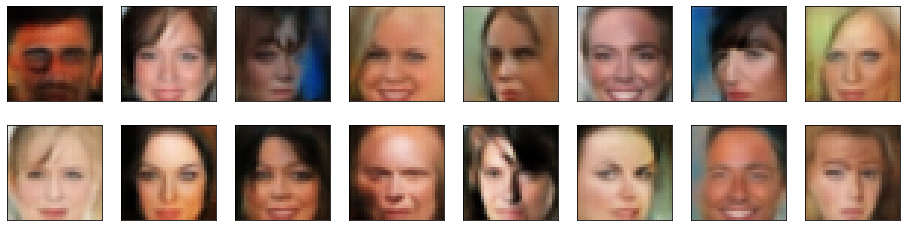

Epoch [   10/   50] | d_loss: 0.9937 | g_loss: 2.8398
Epoch [   10/   50] | d_loss: 0.7824 | g_loss: 1.6834
Epoch [   10/   50] | d_loss: 0.8337 | g_loss: 1.0117
Epoch [   10/   50] | d_loss: 0.5788 | g_loss: 1.6873
Epoch [   10/   50] | d_loss: 1.3331 | g_loss: 3.2622
Epoch [   10/   50] | d_loss: 0.6236 | g_loss: 1.6577
Epoch [   10/   50] | d_loss: 0.5064 | g_loss: 1.4350
Epoch [   10/   50] | d_loss: 0.9570 | g_loss: 1.2413
Epoch [   10/   50] | d_loss: 0.6356 | g_loss: 2.1183
Epoch [   10/   50] | d_loss: -0.0506 | g_loss: 1.7120
Epoch [   10/   50] | d_loss: 1.3147 | g_loss: 2.4568
Epoch [   10/   50] | d_loss: 0.5590 | g_loss: 1.1995
Epoch [   10/   50] | d_loss: -0.0035 | g_loss: 2.8120
Epoch [   10/   50] | d_loss: 1.2876 | g_loss: 2.1217
Epoch [   10/   50] | d_loss: 0.1237 | g_loss: 1.4655
Epoch [   10/   50] | d_loss: 0.9770 | g_loss: 2.2040
Epoch [   10/   50] | d_loss: 0.7442 | g_loss: 0.5798
Epoch [   10/   50] | d_loss: 0.6611 | g_loss: 2.6856
Epoch [   10/   50] | d_lo

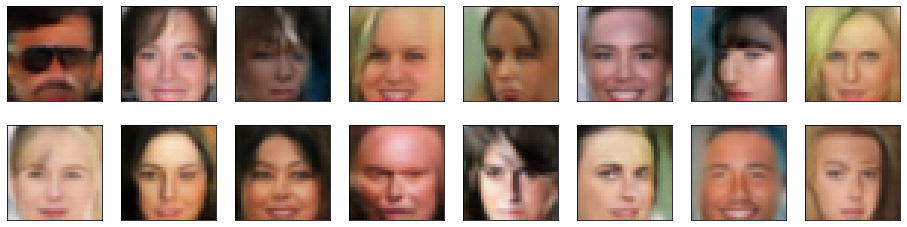

Epoch [   11/   50] | d_loss: 0.3879 | g_loss: 1.5818
Epoch [   11/   50] | d_loss: 0.5945 | g_loss: 2.3041
Epoch [   11/   50] | d_loss: 0.6055 | g_loss: 1.1634
Epoch [   11/   50] | d_loss: 0.4260 | g_loss: 1.5097
Epoch [   11/   50] | d_loss: 0.6885 | g_loss: 1.8026
Epoch [   11/   50] | d_loss: 0.7986 | g_loss: 2.1001
Epoch [   11/   50] | d_loss: 0.9543 | g_loss: 1.9216
Epoch [   11/   50] | d_loss: 1.5058 | g_loss: 1.9753
Epoch [   11/   50] | d_loss: 1.0880 | g_loss: 1.5919
Epoch [   11/   50] | d_loss: 0.1996 | g_loss: 2.5404
Epoch [   11/   50] | d_loss: 0.4981 | g_loss: 1.8419
Epoch [   11/   50] | d_loss: 1.0625 | g_loss: 1.9928
Epoch [   11/   50] | d_loss: 1.3845 | g_loss: 0.5177
Epoch [   11/   50] | d_loss: 0.8376 | g_loss: 2.0758
Epoch [   11/   50] | d_loss: 0.5769 | g_loss: 1.1964
Epoch [   11/   50] | d_loss: 0.5048 | g_loss: 2.5072
Epoch [   11/   50] | d_loss: 0.3657 | g_loss: 1.5678
Epoch [   11/   50] | d_loss: 0.7850 | g_loss: 1.0400
Epoch [   11/   50] | d_loss

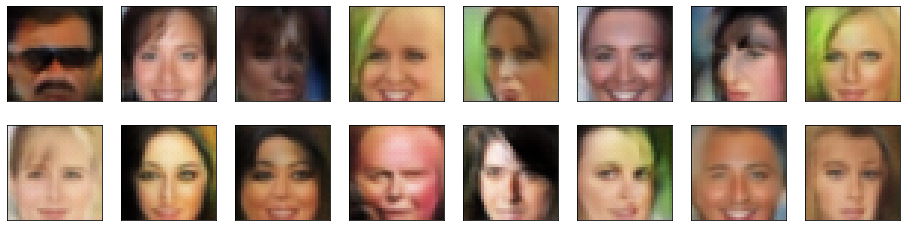

Epoch [   12/   50] | d_loss: 0.7814 | g_loss: 1.9438
Epoch [   12/   50] | d_loss: 0.4717 | g_loss: 0.8863
Epoch [   12/   50] | d_loss: 1.0194 | g_loss: 1.2466
Epoch [   12/   50] | d_loss: 0.9261 | g_loss: 1.5904
Epoch [   12/   50] | d_loss: 1.1222 | g_loss: 2.2636
Epoch [   12/   50] | d_loss: 0.6349 | g_loss: 0.7715
Epoch [   12/   50] | d_loss: 0.4714 | g_loss: 2.6888
Epoch [   12/   50] | d_loss: 0.7996 | g_loss: 1.6707
Epoch [   12/   50] | d_loss: 1.0775 | g_loss: 2.0568
Epoch [   12/   50] | d_loss: 0.5109 | g_loss: 1.4420
Epoch [   12/   50] | d_loss: 0.4981 | g_loss: 1.5908
Epoch [   12/   50] | d_loss: 0.5570 | g_loss: 0.9158
Epoch [   12/   50] | d_loss: 1.0002 | g_loss: 0.6387
Epoch [   12/   50] | d_loss: 0.8603 | g_loss: 1.7985
Epoch [   12/   50] | d_loss: 0.7016 | g_loss: 1.3667
Epoch [   12/   50] | d_loss: 0.6794 | g_loss: 2.3576
Epoch [   12/   50] | d_loss: 0.3639 | g_loss: 0.9745
Epoch [   12/   50] | d_loss: 0.7490 | g_loss: 1.5793
Epoch [   12/   50] | d_loss

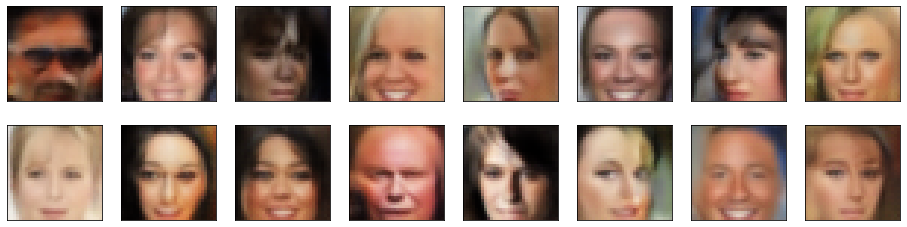

Epoch [   13/   50] | d_loss: 0.6912 | g_loss: 0.7634
Epoch [   13/   50] | d_loss: 0.2651 | g_loss: 0.3398
Epoch [   13/   50] | d_loss: 0.1845 | g_loss: 1.3280
Epoch [   13/   50] | d_loss: 0.8795 | g_loss: 1.9046
Epoch [   13/   50] | d_loss: 0.6918 | g_loss: 2.3761
Epoch [   13/   50] | d_loss: 0.2344 | g_loss: 2.1533
Epoch [   13/   50] | d_loss: 0.3005 | g_loss: 2.3255
Epoch [   13/   50] | d_loss: 0.8442 | g_loss: 1.5437
Epoch [   13/   50] | d_loss: 0.1766 | g_loss: 1.0761
Epoch [   13/   50] | d_loss: 0.6413 | g_loss: 1.2011
Epoch [   13/   50] | d_loss: 0.9241 | g_loss: 0.6921
Epoch [   13/   50] | d_loss: 0.8098 | g_loss: 1.4967
Epoch [   13/   50] | d_loss: 0.9909 | g_loss: 1.1965
Epoch [   13/   50] | d_loss: 0.5716 | g_loss: 2.0322
Epoch [   13/   50] | d_loss: 0.5981 | g_loss: 1.9495
Epoch [   13/   50] | d_loss: 0.9991 | g_loss: 2.3924
Epoch [   13/   50] | d_loss: 0.1778 | g_loss: 1.7624
Epoch [   13/   50] | d_loss: 0.8161 | g_loss: 1.9851
Epoch [   13/   50] | d_loss

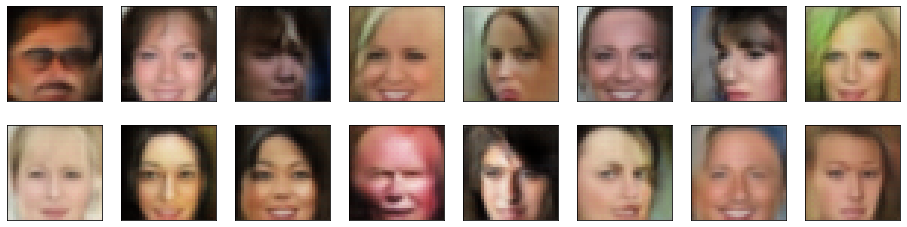

Epoch [   14/   50] | d_loss: 1.1819 | g_loss: 2.1279
Epoch [   14/   50] | d_loss: 0.6847 | g_loss: 2.6057
Epoch [   14/   50] | d_loss: 0.7642 | g_loss: 2.9420
Epoch [   14/   50] | d_loss: 0.4039 | g_loss: 1.2301
Epoch [   14/   50] | d_loss: 1.1453 | g_loss: 1.5167
Epoch [   14/   50] | d_loss: 1.0556 | g_loss: 1.0749
Epoch [   14/   50] | d_loss: 1.1137 | g_loss: 1.7204
Epoch [   14/   50] | d_loss: 1.1263 | g_loss: 2.1198
Epoch [   14/   50] | d_loss: 0.6903 | g_loss: 2.1807
Epoch [   14/   50] | d_loss: 1.0161 | g_loss: 2.3877
Epoch [   14/   50] | d_loss: -0.0261 | g_loss: 2.3341
Epoch [   14/   50] | d_loss: 0.5688 | g_loss: 1.5772
Epoch [   14/   50] | d_loss: 0.9197 | g_loss: 0.8810
Epoch [   14/   50] | d_loss: 0.9169 | g_loss: 2.0634
Epoch [   14/   50] | d_loss: 0.0623 | g_loss: 0.9834
Epoch [   14/   50] | d_loss: 0.6786 | g_loss: 1.1523
Epoch [   14/   50] | d_loss: 0.7903 | g_loss: 1.5419
Epoch [   14/   50] | d_loss: 0.8790 | g_loss: 1.2843
Epoch [   14/   50] | d_los

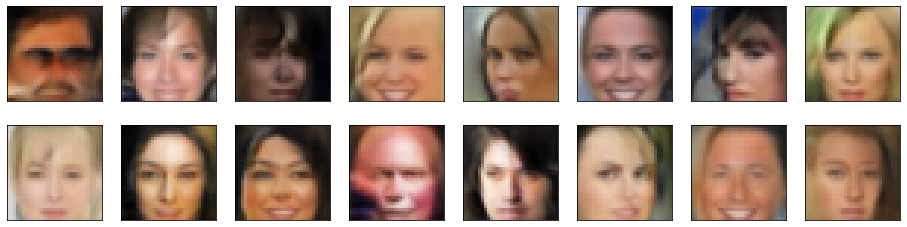

Epoch [   15/   50] | d_loss: 0.9619 | g_loss: 1.4392
Epoch [   15/   50] | d_loss: 0.1159 | g_loss: 1.9015
Epoch [   15/   50] | d_loss: 0.6728 | g_loss: 1.9978
Epoch [   15/   50] | d_loss: 0.3312 | g_loss: 2.2165
Epoch [   15/   50] | d_loss: 0.6629 | g_loss: 2.0530
Epoch [   15/   50] | d_loss: 0.7413 | g_loss: 1.4874
Epoch [   15/   50] | d_loss: 0.8085 | g_loss: 1.8066
Epoch [   15/   50] | d_loss: 0.9307 | g_loss: 1.6369
Epoch [   15/   50] | d_loss: -0.0622 | g_loss: 1.9631
Epoch [   15/   50] | d_loss: 0.6158 | g_loss: 1.4262
Epoch [   15/   50] | d_loss: 0.7123 | g_loss: 1.9319
Epoch [   15/   50] | d_loss: 1.0488 | g_loss: 1.7716
Epoch [   15/   50] | d_loss: 0.5938 | g_loss: 2.0858
Epoch [   15/   50] | d_loss: 0.8635 | g_loss: 1.1357
Epoch [   15/   50] | d_loss: 0.4475 | g_loss: 1.8677
Epoch [   15/   50] | d_loss: 0.5039 | g_loss: 3.0182
Epoch [   15/   50] | d_loss: 0.7630 | g_loss: 3.2018
Epoch [   15/   50] | d_loss: 0.7394 | g_loss: 1.5366
Epoch [   15/   50] | d_los

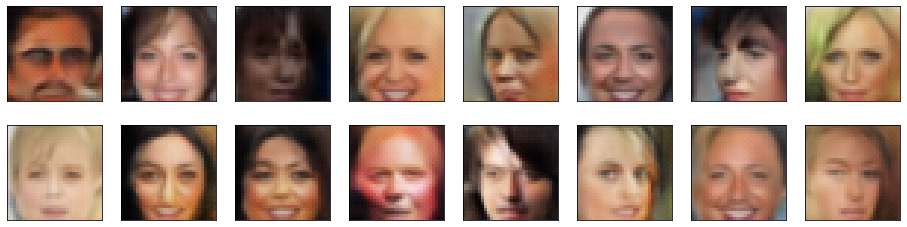

Epoch [   16/   50] | d_loss: 0.1885 | g_loss: 1.6386
Epoch [   16/   50] | d_loss: 0.8131 | g_loss: 0.8014
Epoch [   16/   50] | d_loss: 0.3179 | g_loss: 0.8466
Epoch [   16/   50] | d_loss: 0.9486 | g_loss: 2.3379
Epoch [   16/   50] | d_loss: 0.2789 | g_loss: 1.9155
Epoch [   16/   50] | d_loss: 0.9266 | g_loss: 1.7378
Epoch [   16/   50] | d_loss: 0.1334 | g_loss: 1.9978
Epoch [   16/   50] | d_loss: 1.0960 | g_loss: 1.3293
Epoch [   16/   50] | d_loss: 0.1709 | g_loss: 1.0018
Epoch [   16/   50] | d_loss: 0.4866 | g_loss: 1.5381
Epoch [   16/   50] | d_loss: 0.3532 | g_loss: 1.2910
Epoch [   16/   50] | d_loss: 0.3460 | g_loss: 1.3954
Epoch [   16/   50] | d_loss: 0.6523 | g_loss: 2.2346
Epoch [   16/   50] | d_loss: 0.8807 | g_loss: 2.1281
Epoch [   16/   50] | d_loss: 1.0762 | g_loss: 2.1094
Epoch [   16/   50] | d_loss: 1.2112 | g_loss: 1.1933
Epoch [   16/   50] | d_loss: 0.3283 | g_loss: 1.7773
Epoch [   16/   50] | d_loss: 0.7281 | g_loss: 2.0216
Epoch [   16/   50] | d_loss

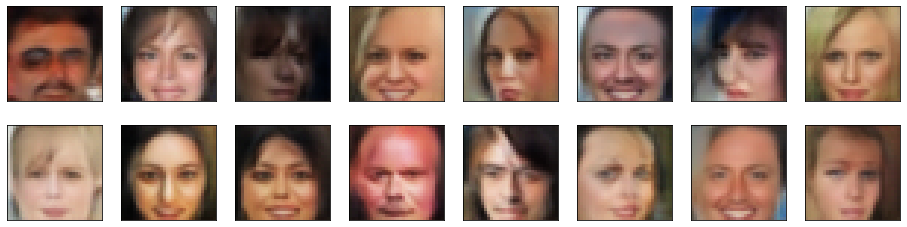

Epoch [   17/   50] | d_loss: 0.7254 | g_loss: 1.2488
Epoch [   17/   50] | d_loss: 0.5725 | g_loss: 2.1360
Epoch [   17/   50] | d_loss: 1.3070 | g_loss: 2.6494
Epoch [   17/   50] | d_loss: 0.0915 | g_loss: 2.4706
Epoch [   17/   50] | d_loss: 0.2869 | g_loss: 1.3783
Epoch [   17/   50] | d_loss: 0.1400 | g_loss: 1.6268
Epoch [   17/   50] | d_loss: 0.9036 | g_loss: 1.5129
Epoch [   17/   50] | d_loss: 1.1402 | g_loss: 1.8127
Epoch [   17/   50] | d_loss: 0.4621 | g_loss: 2.4701
Epoch [   17/   50] | d_loss: 0.5125 | g_loss: 1.8987
Epoch [   17/   50] | d_loss: 0.9524 | g_loss: 1.4280
Epoch [   17/   50] | d_loss: 1.0945 | g_loss: 1.8367
Epoch [   17/   50] | d_loss: 0.4287 | g_loss: 1.6565
Epoch [   17/   50] | d_loss: 0.2607 | g_loss: 1.6537
Epoch [   17/   50] | d_loss: 0.3919 | g_loss: 1.7527
Epoch [   17/   50] | d_loss: 1.0879 | g_loss: 2.4629
Epoch [   17/   50] | d_loss: 0.9374 | g_loss: 2.3388
Epoch [   17/   50] | d_loss: 1.3710 | g_loss: 2.6274
Epoch [   17/   50] | d_loss

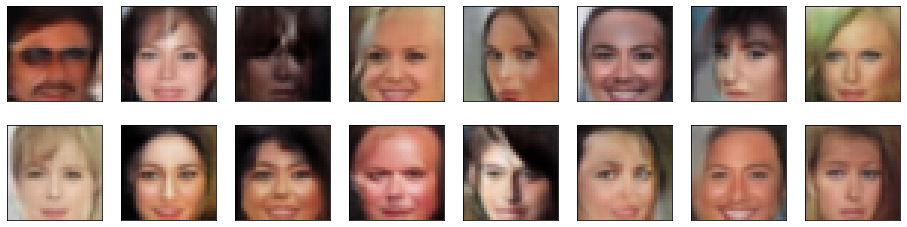

Epoch [   18/   50] | d_loss: 0.6381 | g_loss: 2.0777
Epoch [   18/   50] | d_loss: 0.9114 | g_loss: 2.7717
Epoch [   18/   50] | d_loss: 1.1275 | g_loss: 1.1686
Epoch [   18/   50] | d_loss: 0.1828 | g_loss: 1.5861
Epoch [   18/   50] | d_loss: 0.7922 | g_loss: 1.7985
Epoch [   18/   50] | d_loss: 0.4955 | g_loss: 1.9282
Epoch [   18/   50] | d_loss: 0.2010 | g_loss: 1.5977
Epoch [   18/   50] | d_loss: 0.5560 | g_loss: 2.5358
Epoch [   18/   50] | d_loss: 0.4620 | g_loss: 1.5807
Epoch [   18/   50] | d_loss: 0.6972 | g_loss: 1.2411
Epoch [   18/   50] | d_loss: 0.8475 | g_loss: 1.6171
Epoch [   18/   50] | d_loss: 0.2522 | g_loss: 1.6125
Epoch [   18/   50] | d_loss: 1.1975 | g_loss: 2.0633
Epoch [   18/   50] | d_loss: 1.0780 | g_loss: 1.4268
Epoch [   18/   50] | d_loss: 0.1218 | g_loss: 2.4308
Epoch [   18/   50] | d_loss: 0.4703 | g_loss: 2.4246
Epoch [   18/   50] | d_loss: 1.1909 | g_loss: 2.1519
Epoch [   18/   50] | d_loss: 0.4600 | g_loss: 1.4548
Epoch [   18/   50] | d_loss

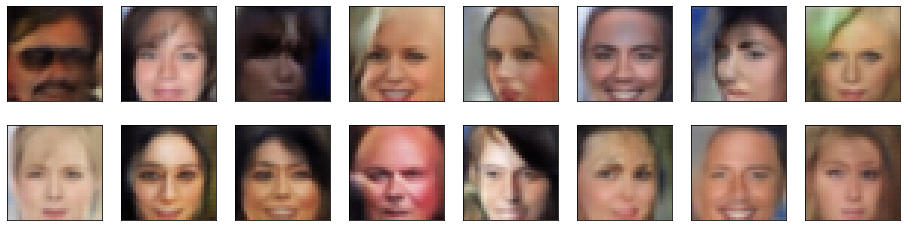

Epoch [   19/   50] | d_loss: 0.9551 | g_loss: 2.0217
Epoch [   19/   50] | d_loss: 0.5858 | g_loss: 1.7344
Epoch [   19/   50] | d_loss: 1.0763 | g_loss: 1.7196
Epoch [   19/   50] | d_loss: 0.6764 | g_loss: 2.3221
Epoch [   19/   50] | d_loss: 0.4638 | g_loss: 1.9854
Epoch [   19/   50] | d_loss: 0.5058 | g_loss: 1.0296
Epoch [   19/   50] | d_loss: 1.0545 | g_loss: 0.7150
Epoch [   19/   50] | d_loss: 0.6011 | g_loss: 2.6868
Epoch [   19/   50] | d_loss: 0.2969 | g_loss: 1.7646
Epoch [   19/   50] | d_loss: 0.9445 | g_loss: 1.1175
Epoch [   19/   50] | d_loss: 0.6735 | g_loss: 2.1684
Epoch [   19/   50] | d_loss: 0.8625 | g_loss: 2.4512
Epoch [   19/   50] | d_loss: 0.8807 | g_loss: 1.8806
Epoch [   19/   50] | d_loss: 0.4039 | g_loss: 0.8216
Epoch [   19/   50] | d_loss: 0.6955 | g_loss: 0.8549
Epoch [   19/   50] | d_loss: 0.4323 | g_loss: 1.3979
Epoch [   19/   50] | d_loss: 1.0718 | g_loss: 1.9255
Epoch [   19/   50] | d_loss: 0.4664 | g_loss: 2.0766
Epoch [   19/   50] | d_loss

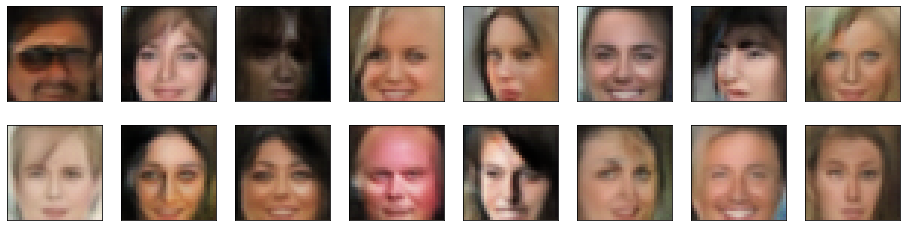

Epoch [   20/   50] | d_loss: 0.8978 | g_loss: 1.3713
Epoch [   20/   50] | d_loss: 0.7714 | g_loss: 1.1475
Epoch [   20/   50] | d_loss: 0.6650 | g_loss: 1.9202
Epoch [   20/   50] | d_loss: 0.6714 | g_loss: 2.5156
Epoch [   20/   50] | d_loss: 0.9814 | g_loss: 1.6550
Epoch [   20/   50] | d_loss: 0.7681 | g_loss: 1.7231
Epoch [   20/   50] | d_loss: 0.9300 | g_loss: 2.1572
Epoch [   20/   50] | d_loss: 0.9137 | g_loss: 0.8541
Epoch [   20/   50] | d_loss: 0.4322 | g_loss: 2.2162
Epoch [   20/   50] | d_loss: 0.9811 | g_loss: 2.0441
Epoch [   20/   50] | d_loss: 0.8208 | g_loss: 1.5373
Epoch [   20/   50] | d_loss: 0.9011 | g_loss: 1.9367
Epoch [   20/   50] | d_loss: 0.5798 | g_loss: 1.3297
Epoch [   20/   50] | d_loss: 0.4703 | g_loss: 2.1455
Epoch [   20/   50] | d_loss: 1.2037 | g_loss: 1.5877
Epoch [   20/   50] | d_loss: 0.8988 | g_loss: 1.5057
Epoch [   20/   50] | d_loss: 1.1258 | g_loss: 1.4367
Epoch [   20/   50] | d_loss: 0.5557 | g_loss: 1.2218
Epoch [   20/   50] | d_loss

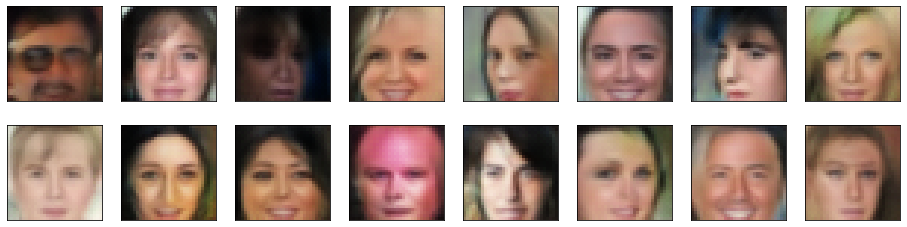

Epoch [   21/   50] | d_loss: 1.1929 | g_loss: 2.8714
Epoch [   21/   50] | d_loss: 0.6780 | g_loss: 1.0850
Epoch [   21/   50] | d_loss: 0.2527 | g_loss: 2.1061
Epoch [   21/   50] | d_loss: 0.2006 | g_loss: 2.5256
Epoch [   21/   50] | d_loss: 0.9958 | g_loss: 1.7931
Epoch [   21/   50] | d_loss: 0.6862 | g_loss: 2.2750
Epoch [   21/   50] | d_loss: 0.7752 | g_loss: 2.1934
Epoch [   21/   50] | d_loss: 1.1249 | g_loss: 1.7910
Epoch [   21/   50] | d_loss: 0.6986 | g_loss: 1.8893
Epoch [   21/   50] | d_loss: 1.0325 | g_loss: 2.1611
Epoch [   21/   50] | d_loss: 0.8376 | g_loss: 1.8565
Epoch [   21/   50] | d_loss: 0.5963 | g_loss: 2.5908
Epoch [   21/   50] | d_loss: 0.5247 | g_loss: 2.4158
Epoch [   21/   50] | d_loss: 1.0594 | g_loss: 1.8533
Epoch [   21/   50] | d_loss: 0.4261 | g_loss: 1.6029
Epoch [   21/   50] | d_loss: 0.9947 | g_loss: 2.5279
Epoch [   21/   50] | d_loss: 0.7898 | g_loss: 1.4083
Epoch [   21/   50] | d_loss: 0.9727 | g_loss: 1.9902
Epoch [   21/   50] | d_loss

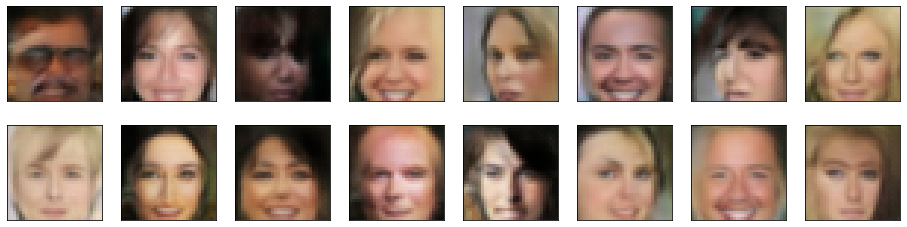

Epoch [   22/   50] | d_loss: 1.0094 | g_loss: 2.0029
Epoch [   22/   50] | d_loss: 1.0684 | g_loss: 2.3663
Epoch [   22/   50] | d_loss: 0.6502 | g_loss: 1.8954
Epoch [   22/   50] | d_loss: 0.6158 | g_loss: 1.8263
Epoch [   22/   50] | d_loss: 1.0048 | g_loss: 2.2467
Epoch [   22/   50] | d_loss: 0.8376 | g_loss: 2.6592
Epoch [   22/   50] | d_loss: 0.4898 | g_loss: 1.7768
Epoch [   22/   50] | d_loss: 0.4873 | g_loss: 1.6982
Epoch [   22/   50] | d_loss: 0.2877 | g_loss: 1.4386
Epoch [   22/   50] | d_loss: 0.4778 | g_loss: 2.3915
Epoch [   22/   50] | d_loss: 0.4894 | g_loss: 1.7550
Epoch [   22/   50] | d_loss: 0.9970 | g_loss: 3.5602
Epoch [   22/   50] | d_loss: 0.2577 | g_loss: 1.9995
Epoch [   22/   50] | d_loss: 0.8745 | g_loss: 1.4764
Epoch [   22/   50] | d_loss: 0.5052 | g_loss: 2.0379
Epoch [   22/   50] | d_loss: 0.6496 | g_loss: 2.2779
Epoch [   22/   50] | d_loss: 0.8069 | g_loss: 1.3188
Epoch [   22/   50] | d_loss: 0.2774 | g_loss: 1.5618
Epoch [   22/   50] | d_loss

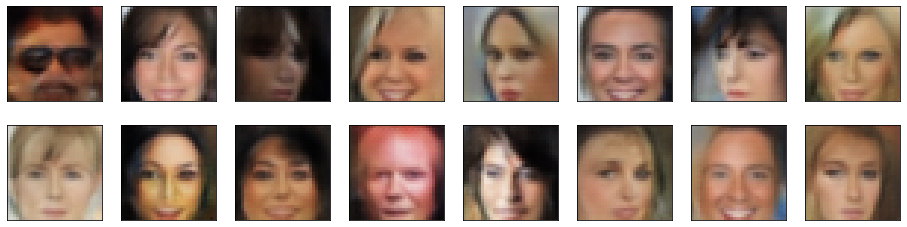

Epoch [   23/   50] | d_loss: 0.4948 | g_loss: 1.4178
Epoch [   23/   50] | d_loss: 0.6087 | g_loss: 1.8100
Epoch [   23/   50] | d_loss: 0.9761 | g_loss: 1.5593
Epoch [   23/   50] | d_loss: 0.2530 | g_loss: 1.5010
Epoch [   23/   50] | d_loss: 0.6260 | g_loss: 1.2939
Epoch [   23/   50] | d_loss: 0.6157 | g_loss: 2.6055
Epoch [   23/   50] | d_loss: 0.7760 | g_loss: 1.6025
Epoch [   23/   50] | d_loss: 0.3091 | g_loss: 1.8264
Epoch [   23/   50] | d_loss: 0.5401 | g_loss: 2.6329
Epoch [   23/   50] | d_loss: 1.1355 | g_loss: 2.1867
Epoch [   23/   50] | d_loss: 0.1996 | g_loss: 1.7796
Epoch [   23/   50] | d_loss: 0.7730 | g_loss: 2.0255
Epoch [   23/   50] | d_loss: 0.5272 | g_loss: 2.0228
Epoch [   23/   50] | d_loss: 0.9125 | g_loss: 1.1372
Epoch [   23/   50] | d_loss: 0.5049 | g_loss: 2.6858
Epoch [   23/   50] | d_loss: 1.0018 | g_loss: 1.7683
Epoch [   23/   50] | d_loss: 0.6074 | g_loss: 1.5241
Epoch [   23/   50] | d_loss: 0.8687 | g_loss: 1.4091
Epoch [   23/   50] | d_loss

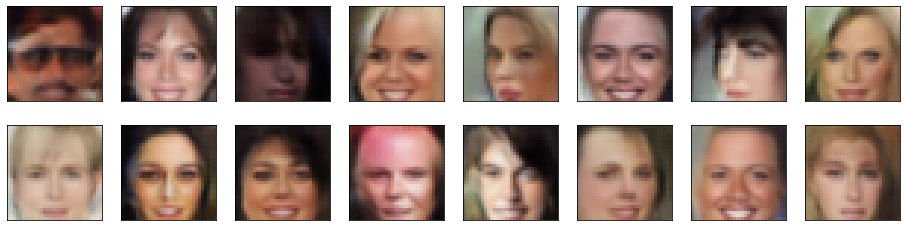

Epoch [   24/   50] | d_loss: 0.7646 | g_loss: 1.3987
Epoch [   24/   50] | d_loss: 0.3430 | g_loss: 1.7486
Epoch [   24/   50] | d_loss: 0.4229 | g_loss: 1.8023
Epoch [   24/   50] | d_loss: 0.9542 | g_loss: 1.6745
Epoch [   24/   50] | d_loss: 0.7454 | g_loss: 2.6137
Epoch [   24/   50] | d_loss: 0.4977 | g_loss: 1.7071
Epoch [   24/   50] | d_loss: 1.1070 | g_loss: 1.4039
Epoch [   24/   50] | d_loss: 0.8762 | g_loss: 1.5412
Epoch [   24/   50] | d_loss: 0.6443 | g_loss: 3.1889
Epoch [   24/   50] | d_loss: 0.3502 | g_loss: 1.2609
Epoch [   24/   50] | d_loss: 0.5036 | g_loss: 1.1790
Epoch [   24/   50] | d_loss: 1.2245 | g_loss: 1.5529
Epoch [   24/   50] | d_loss: 0.6507 | g_loss: 1.5428
Epoch [   24/   50] | d_loss: 0.7269 | g_loss: 2.6646
Epoch [   24/   50] | d_loss: 0.8101 | g_loss: 1.9473
Epoch [   24/   50] | d_loss: 0.6713 | g_loss: 1.9043
Epoch [   24/   50] | d_loss: 0.6091 | g_loss: 1.1598
Epoch [   24/   50] | d_loss: 0.5548 | g_loss: 1.4182
Epoch [   24/   50] | d_loss

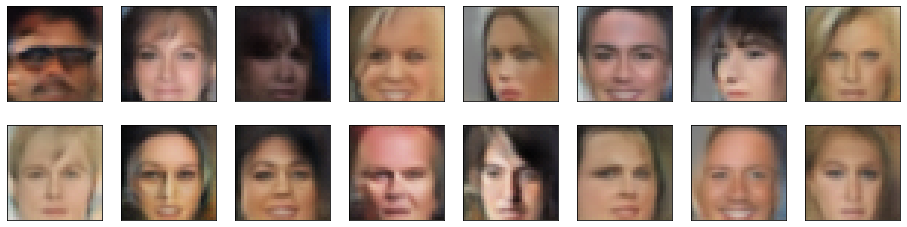

Epoch [   25/   50] | d_loss: 0.8041 | g_loss: 1.2869
Epoch [   25/   50] | d_loss: 0.5305 | g_loss: 2.2810
Epoch [   25/   50] | d_loss: 0.8024 | g_loss: 1.5371
Epoch [   25/   50] | d_loss: 0.3390 | g_loss: 1.5222
Epoch [   25/   50] | d_loss: 1.3622 | g_loss: 1.9387
Epoch [   25/   50] | d_loss: 0.3743 | g_loss: 1.8907
Epoch [   25/   50] | d_loss: 0.2648 | g_loss: 2.0927
Epoch [   25/   50] | d_loss: 0.0730 | g_loss: 2.2580
Epoch [   25/   50] | d_loss: 0.5051 | g_loss: 1.5309
Epoch [   25/   50] | d_loss: 0.5371 | g_loss: 2.8545
Epoch [   25/   50] | d_loss: 0.9479 | g_loss: 2.0351
Epoch [   25/   50] | d_loss: 1.0960 | g_loss: 2.1403
Epoch [   25/   50] | d_loss: 0.1762 | g_loss: 1.6595
Epoch [   25/   50] | d_loss: 0.6256 | g_loss: 1.2399
Epoch [   25/   50] | d_loss: 0.4511 | g_loss: 2.4758
Epoch [   25/   50] | d_loss: 1.1495 | g_loss: 1.8818
Epoch [   25/   50] | d_loss: 0.8183 | g_loss: 1.1734
Epoch [   25/   50] | d_loss: 0.8881 | g_loss: 2.8590
Epoch [   25/   50] | d_loss

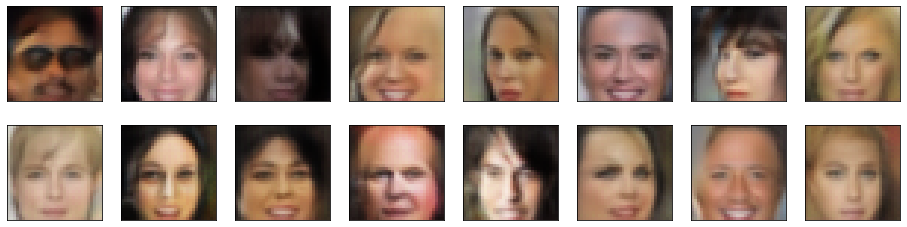

Epoch [   26/   50] | d_loss: 0.6892 | g_loss: 2.4713
Epoch [   26/   50] | d_loss: 0.7373 | g_loss: 2.3415
Epoch [   26/   50] | d_loss: 0.9757 | g_loss: 0.9348
Epoch [   26/   50] | d_loss: 0.4967 | g_loss: 1.5895
Epoch [   26/   50] | d_loss: 0.0109 | g_loss: 1.0797
Epoch [   26/   50] | d_loss: 0.9658 | g_loss: 1.5561
Epoch [   26/   50] | d_loss: 0.7492 | g_loss: 1.7997
Epoch [   26/   50] | d_loss: 0.8058 | g_loss: 1.8521
Epoch [   26/   50] | d_loss: 0.7948 | g_loss: 1.1569
Epoch [   26/   50] | d_loss: 0.8871 | g_loss: 2.0362
Epoch [   26/   50] | d_loss: 1.0974 | g_loss: 2.3541
Epoch [   26/   50] | d_loss: 0.7928 | g_loss: 2.0178
Epoch [   26/   50] | d_loss: 1.0002 | g_loss: 1.7588
Epoch [   26/   50] | d_loss: 0.7480 | g_loss: 1.5970
Epoch [   26/   50] | d_loss: 0.1914 | g_loss: 1.3982
Epoch [   26/   50] | d_loss: 1.1192 | g_loss: 1.9983
Epoch [   26/   50] | d_loss: 0.9157 | g_loss: 2.3791
Epoch [   26/   50] | d_loss: 0.3244 | g_loss: 1.9320
Epoch [   26/   50] | d_loss

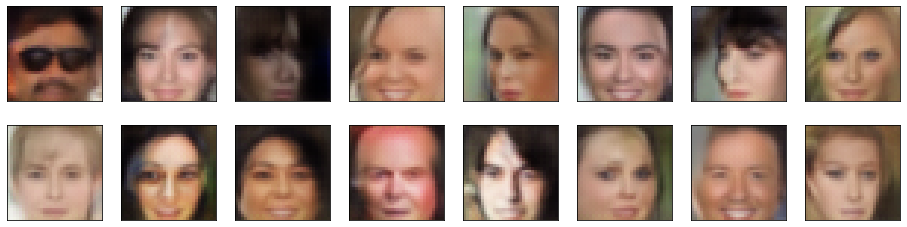

Epoch [   27/   50] | d_loss: 0.2190 | g_loss: 3.0045
Epoch [   27/   50] | d_loss: 0.7076 | g_loss: 2.0671
Epoch [   27/   50] | d_loss: 0.5173 | g_loss: 1.5864
Epoch [   27/   50] | d_loss: 0.5687 | g_loss: 1.0290
Epoch [   27/   50] | d_loss: 0.7008 | g_loss: 2.0567
Epoch [   27/   50] | d_loss: 0.0409 | g_loss: 2.1002
Epoch [   27/   50] | d_loss: 0.9132 | g_loss: 1.6362
Epoch [   27/   50] | d_loss: 0.7461 | g_loss: 2.0892
Epoch [   27/   50] | d_loss: 0.6237 | g_loss: 1.8839
Epoch [   27/   50] | d_loss: 0.5019 | g_loss: 1.2480
Epoch [   27/   50] | d_loss: 0.8738 | g_loss: 2.0470
Epoch [   27/   50] | d_loss: 0.5411 | g_loss: 1.3129
Epoch [   27/   50] | d_loss: 0.9295 | g_loss: 1.2927
Epoch [   27/   50] | d_loss: 1.0209 | g_loss: 1.6265
Epoch [   27/   50] | d_loss: 0.7744 | g_loss: 1.4138
Epoch [   27/   50] | d_loss: 0.7222 | g_loss: 2.2842
Epoch [   27/   50] | d_loss: 0.7075 | g_loss: 2.0429
Epoch [   27/   50] | d_loss: 0.8440 | g_loss: 2.2152
Epoch [   27/   50] | d_loss

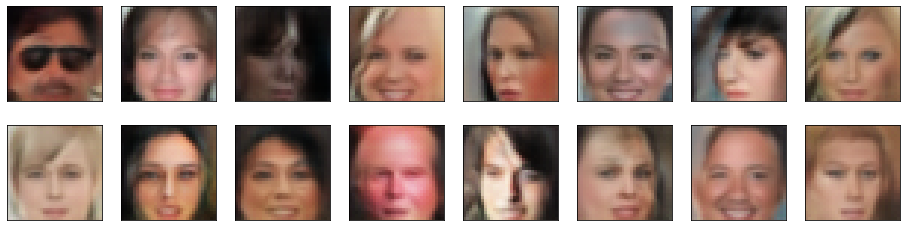

Epoch [   28/   50] | d_loss: 0.7297 | g_loss: 2.0477
Epoch [   28/   50] | d_loss: 0.9509 | g_loss: 2.1727
Epoch [   28/   50] | d_loss: 0.4222 | g_loss: 2.4020
Epoch [   28/   50] | d_loss: 0.2378 | g_loss: 2.1735
Epoch [   28/   50] | d_loss: 0.1680 | g_loss: 1.5869
Epoch [   28/   50] | d_loss: 0.3922 | g_loss: 1.9737
Epoch [   28/   50] | d_loss: 0.4557 | g_loss: 2.2455
Epoch [   28/   50] | d_loss: 0.2392 | g_loss: 1.6768
Epoch [   28/   50] | d_loss: 0.8599 | g_loss: 1.4154
Epoch [   28/   50] | d_loss: 0.5055 | g_loss: 2.2792
Epoch [   28/   50] | d_loss: 1.2996 | g_loss: 2.2372
Epoch [   28/   50] | d_loss: 1.2010 | g_loss: 1.6064
Epoch [   28/   50] | d_loss: 1.0094 | g_loss: 2.2235
Epoch [   28/   50] | d_loss: 0.7960 | g_loss: 2.4072
Epoch [   28/   50] | d_loss: 0.7661 | g_loss: 1.9792
Epoch [   28/   50] | d_loss: 0.6773 | g_loss: 1.7760
Epoch [   28/   50] | d_loss: 0.4636 | g_loss: 1.6426
Epoch [   28/   50] | d_loss: 0.6601 | g_loss: 1.8935
Epoch [   28/   50] | d_loss

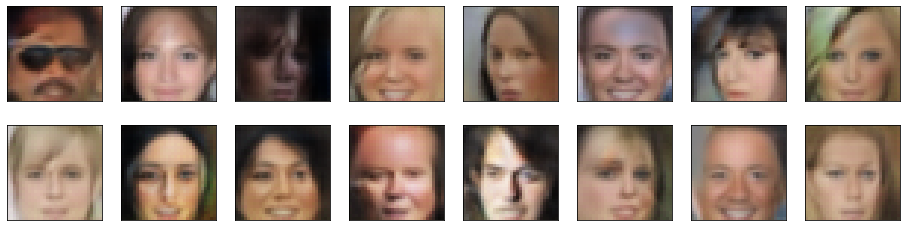

Epoch [   29/   50] | d_loss: 1.2318 | g_loss: 0.8618
Epoch [   29/   50] | d_loss: 0.9875 | g_loss: 1.5431
Epoch [   29/   50] | d_loss: 0.5297 | g_loss: 1.6981
Epoch [   29/   50] | d_loss: 0.1827 | g_loss: 1.8397
Epoch [   29/   50] | d_loss: 0.7246 | g_loss: 2.9925
Epoch [   29/   50] | d_loss: 0.7451 | g_loss: 1.8097
Epoch [   29/   50] | d_loss: 0.0518 | g_loss: 1.9776
Epoch [   29/   50] | d_loss: 0.9422 | g_loss: 1.6335
Epoch [   29/   50] | d_loss: 0.6326 | g_loss: 0.9728
Epoch [   29/   50] | d_loss: 1.4318 | g_loss: 1.5647
Epoch [   29/   50] | d_loss: 0.4458 | g_loss: 1.6981
Epoch [   29/   50] | d_loss: 0.2281 | g_loss: 1.8401
Epoch [   29/   50] | d_loss: 0.8581 | g_loss: 1.4329
Epoch [   29/   50] | d_loss: 0.9575 | g_loss: 1.9935
Epoch [   29/   50] | d_loss: 0.9708 | g_loss: 1.9915
Epoch [   29/   50] | d_loss: 1.0737 | g_loss: 2.1461
Epoch [   29/   50] | d_loss: 0.8340 | g_loss: 1.6826
Epoch [   29/   50] | d_loss: 0.4220 | g_loss: 2.2790
Epoch [   29/   50] | d_loss

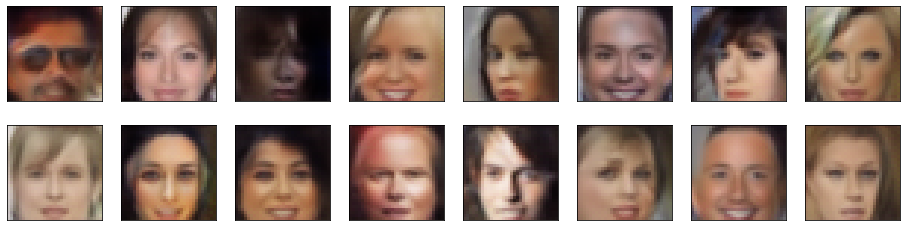

Epoch [   30/   50] | d_loss: 0.6069 | g_loss: 2.1101
Epoch [   30/   50] | d_loss: 0.2462 | g_loss: 1.1959
Epoch [   30/   50] | d_loss: 1.0910 | g_loss: 2.0127
Epoch [   30/   50] | d_loss: 0.8011 | g_loss: 1.9466
Epoch [   30/   50] | d_loss: 0.5105 | g_loss: 2.2684
Epoch [   30/   50] | d_loss: 0.7256 | g_loss: 1.8522
Epoch [   30/   50] | d_loss: 0.8313 | g_loss: 1.8768
Epoch [   30/   50] | d_loss: 0.8608 | g_loss: 1.5928
Epoch [   30/   50] | d_loss: 0.5496 | g_loss: 1.8556
Epoch [   30/   50] | d_loss: 0.2459 | g_loss: 1.7592
Epoch [   30/   50] | d_loss: 0.8818 | g_loss: 1.7389
Epoch [   30/   50] | d_loss: 0.9801 | g_loss: 1.6761
Epoch [   30/   50] | d_loss: 1.0024 | g_loss: 1.3426
Epoch [   30/   50] | d_loss: 1.1452 | g_loss: 1.2821
Epoch [   30/   50] | d_loss: 0.3478 | g_loss: 1.2299
Epoch [   30/   50] | d_loss: 0.9504 | g_loss: 0.9597
Epoch [   30/   50] | d_loss: 1.0308 | g_loss: 1.9958
Epoch [   30/   50] | d_loss: 0.5332 | g_loss: 1.7066
Epoch [   30/   50] | d_loss

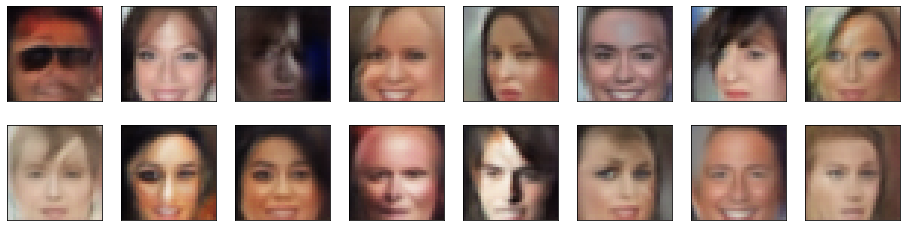

Epoch [   31/   50] | d_loss: 0.4057 | g_loss: 2.2596
Epoch [   31/   50] | d_loss: 1.0282 | g_loss: 2.0231
Epoch [   31/   50] | d_loss: 0.4898 | g_loss: 1.8515
Epoch [   31/   50] | d_loss: 0.1586 | g_loss: 2.1463
Epoch [   31/   50] | d_loss: 0.6558 | g_loss: 1.4144
Epoch [   31/   50] | d_loss: 0.6142 | g_loss: 1.9768
Epoch [   31/   50] | d_loss: 1.0055 | g_loss: 1.5845
Epoch [   31/   50] | d_loss: 0.4215 | g_loss: 1.7879
Epoch [   31/   50] | d_loss: 0.6022 | g_loss: 1.6594
Epoch [   31/   50] | d_loss: 0.6574 | g_loss: 1.8933
Epoch [   31/   50] | d_loss: 0.7979 | g_loss: 1.6921
Epoch [   31/   50] | d_loss: 0.7658 | g_loss: 2.3030
Epoch [   31/   50] | d_loss: 1.2580 | g_loss: 2.6732
Epoch [   31/   50] | d_loss: 0.6144 | g_loss: 1.6320
Epoch [   31/   50] | d_loss: 0.5860 | g_loss: 1.6436
Epoch [   31/   50] | d_loss: 0.6468 | g_loss: 1.1959
Epoch [   31/   50] | d_loss: 0.9131 | g_loss: 2.0704
Epoch [   31/   50] | d_loss: 0.2820 | g_loss: 1.0720
Epoch [   31/   50] | d_loss

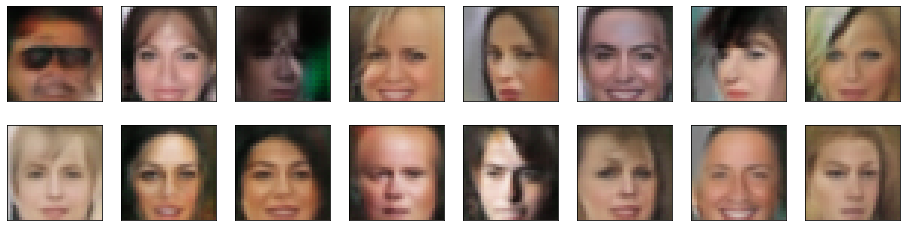

Epoch [   32/   50] | d_loss: 0.8752 | g_loss: 1.6670
Epoch [   32/   50] | d_loss: 0.4504 | g_loss: 1.6046
Epoch [   32/   50] | d_loss: 0.4107 | g_loss: 1.9050
Epoch [   32/   50] | d_loss: 0.1408 | g_loss: 1.5108
Epoch [   32/   50] | d_loss: 0.2229 | g_loss: 2.0180
Epoch [   32/   50] | d_loss: 0.9141 | g_loss: 1.8183
Epoch [   32/   50] | d_loss: 1.0449 | g_loss: 2.1092
Epoch [   32/   50] | d_loss: 0.7507 | g_loss: 2.0884
Epoch [   32/   50] | d_loss: 0.4682 | g_loss: 0.8426
Epoch [   32/   50] | d_loss: 0.0615 | g_loss: 1.3921
Epoch [   32/   50] | d_loss: 0.7479 | g_loss: 1.6861
Epoch [   32/   50] | d_loss: 0.7824 | g_loss: 1.7422
Epoch [   32/   50] | d_loss: 0.5568 | g_loss: 2.0094
Epoch [   32/   50] | d_loss: 0.8184 | g_loss: 2.6841
Epoch [   32/   50] | d_loss: 0.7768 | g_loss: 1.4780
Epoch [   32/   50] | d_loss: 0.5351 | g_loss: 1.5589
Epoch [   32/   50] | d_loss: 0.8291 | g_loss: 1.5596
Epoch [   32/   50] | d_loss: 0.4771 | g_loss: 1.6648
Epoch [   32/   50] | d_loss

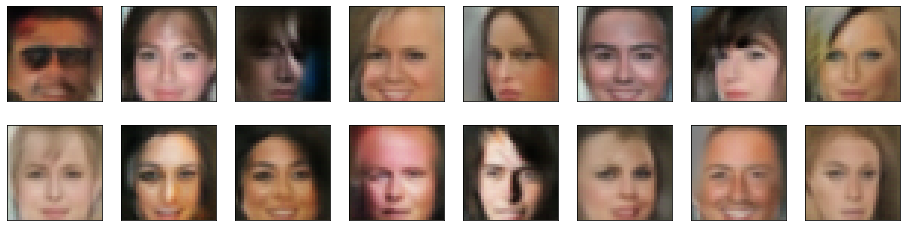

Epoch [   33/   50] | d_loss: 0.5360 | g_loss: 1.4103
Epoch [   33/   50] | d_loss: 0.6644 | g_loss: 1.1680
Epoch [   33/   50] | d_loss: 0.6513 | g_loss: 1.4460
Epoch [   33/   50] | d_loss: 0.7561 | g_loss: 1.3866
Epoch [   33/   50] | d_loss: 1.0084 | g_loss: 1.6730
Epoch [   33/   50] | d_loss: 0.9675 | g_loss: 1.2065
Epoch [   33/   50] | d_loss: 0.8571 | g_loss: 1.7080
Epoch [   33/   50] | d_loss: 0.9177 | g_loss: 1.8968
Epoch [   33/   50] | d_loss: 0.8590 | g_loss: 2.1763
Epoch [   33/   50] | d_loss: 0.7898 | g_loss: 2.0289
Epoch [   33/   50] | d_loss: 1.1367 | g_loss: 2.2811
Epoch [   33/   50] | d_loss: 0.4934 | g_loss: 1.9941
Epoch [   33/   50] | d_loss: 1.0822 | g_loss: 1.9999
Epoch [   33/   50] | d_loss: 1.2090 | g_loss: 2.0167
Epoch [   33/   50] | d_loss: 0.4628 | g_loss: 1.3959
Epoch [   33/   50] | d_loss: 1.0458 | g_loss: 1.4407
Epoch [   33/   50] | d_loss: 0.7513 | g_loss: 1.9675
Epoch [   33/   50] | d_loss: 1.0073 | g_loss: 1.5183
Epoch [   33/   50] | d_loss

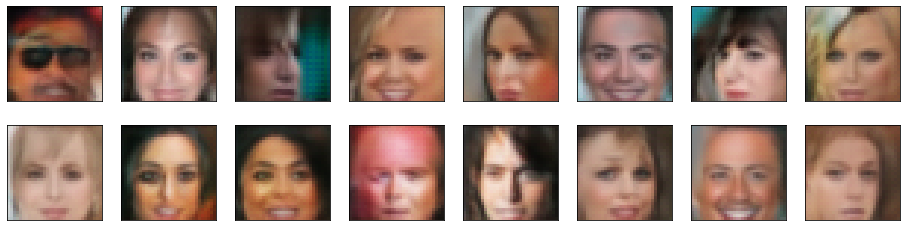

Epoch [   34/   50] | d_loss: 1.0058 | g_loss: 2.7073
Epoch [   34/   50] | d_loss: 0.4566 | g_loss: 2.0442
Epoch [   34/   50] | d_loss: 1.0020 | g_loss: 1.7107
Epoch [   34/   50] | d_loss: 0.5906 | g_loss: 1.4474
Epoch [   34/   50] | d_loss: 0.2727 | g_loss: 2.1101
Epoch [   34/   50] | d_loss: 0.6134 | g_loss: 2.2800
Epoch [   34/   50] | d_loss: 0.4631 | g_loss: 0.9020
Epoch [   34/   50] | d_loss: 0.5378 | g_loss: 0.7126
Epoch [   34/   50] | d_loss: 0.9080 | g_loss: 2.0061
Epoch [   34/   50] | d_loss: 0.4193 | g_loss: 1.1621
Epoch [   34/   50] | d_loss: 1.1068 | g_loss: 1.7665
Epoch [   34/   50] | d_loss: 0.5633 | g_loss: 1.8948
Epoch [   34/   50] | d_loss: 1.0464 | g_loss: 1.7962
Epoch [   34/   50] | d_loss: 0.5645 | g_loss: 2.5858
Epoch [   34/   50] | d_loss: 0.6638 | g_loss: 1.6452
Epoch [   34/   50] | d_loss: 0.2707 | g_loss: 2.2429
Epoch [   34/   50] | d_loss: 0.7341 | g_loss: 2.2291
Epoch [   34/   50] | d_loss: 0.1635 | g_loss: 2.2154
Epoch [   34/   50] | d_loss

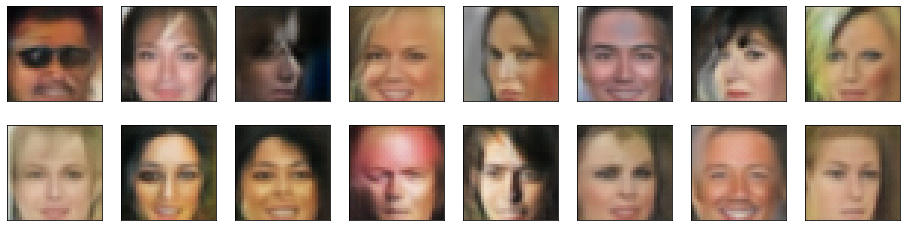

Epoch [   35/   50] | d_loss: 0.1928 | g_loss: 1.3356
Epoch [   35/   50] | d_loss: 0.1266 | g_loss: 1.2096
Epoch [   35/   50] | d_loss: 0.7288 | g_loss: 2.2805
Epoch [   35/   50] | d_loss: 0.4163 | g_loss: 2.1607
Epoch [   35/   50] | d_loss: 0.9828 | g_loss: 1.7307
Epoch [   35/   50] | d_loss: 0.1625 | g_loss: 1.4393
Epoch [   35/   50] | d_loss: 0.1838 | g_loss: 2.1469
Epoch [   35/   50] | d_loss: 0.5353 | g_loss: 1.1013
Epoch [   35/   50] | d_loss: 0.0463 | g_loss: 1.7763
Epoch [   35/   50] | d_loss: 0.3403 | g_loss: 1.7133
Epoch [   35/   50] | d_loss: 0.8603 | g_loss: 2.3103
Epoch [   35/   50] | d_loss: 0.3135 | g_loss: 1.4349
Epoch [   35/   50] | d_loss: 0.7560 | g_loss: 1.5916
Epoch [   35/   50] | d_loss: 0.9159 | g_loss: 1.7081
Epoch [   35/   50] | d_loss: 0.8613 | g_loss: 1.8183
Epoch [   35/   50] | d_loss: 0.6616 | g_loss: 1.9550
Epoch [   35/   50] | d_loss: 1.2020 | g_loss: 1.7215
Epoch [   35/   50] | d_loss: 1.2969 | g_loss: 1.7091
Epoch [   35/   50] | d_loss

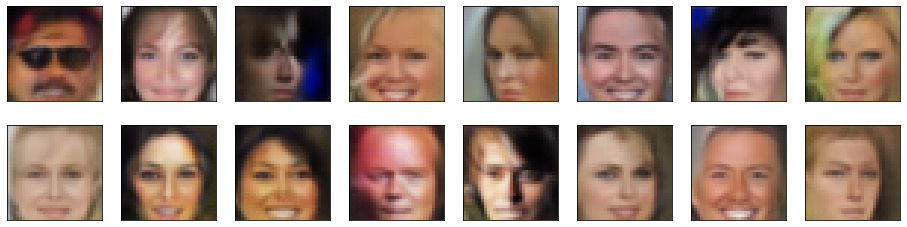

Epoch [   36/   50] | d_loss: 1.1897 | g_loss: 1.7922
Epoch [   36/   50] | d_loss: 1.1786 | g_loss: 1.7776
Epoch [   36/   50] | d_loss: 0.9882 | g_loss: 2.2485
Epoch [   36/   50] | d_loss: 0.1594 | g_loss: 1.5745
Epoch [   36/   50] | d_loss: 0.4178 | g_loss: 1.4137
Epoch [   36/   50] | d_loss: 1.0177 | g_loss: 1.7229
Epoch [   36/   50] | d_loss: 0.6916 | g_loss: 2.2002
Epoch [   36/   50] | d_loss: 0.4527 | g_loss: 1.6460
Epoch [   36/   50] | d_loss: 0.4253 | g_loss: 1.4829
Epoch [   36/   50] | d_loss: 0.3498 | g_loss: 1.7919
Epoch [   36/   50] | d_loss: 0.6879 | g_loss: 1.5948
Epoch [   36/   50] | d_loss: 1.3943 | g_loss: 1.4506
Epoch [   36/   50] | d_loss: 0.2785 | g_loss: 1.9916
Epoch [   36/   50] | d_loss: 1.1123 | g_loss: 1.7590
Epoch [   36/   50] | d_loss: 0.6694 | g_loss: 2.2804
Epoch [   36/   50] | d_loss: 0.6649 | g_loss: 1.7538
Epoch [   36/   50] | d_loss: 1.0375 | g_loss: 1.4927
Epoch [   36/   50] | d_loss: 0.5684 | g_loss: 1.7903
Epoch [   36/   50] | d_loss

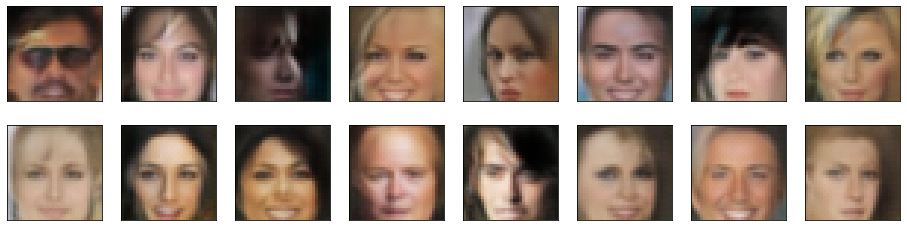

Epoch [   37/   50] | d_loss: 0.0691 | g_loss: 2.2957
Epoch [   37/   50] | d_loss: 0.6989 | g_loss: 1.5364
Epoch [   37/   50] | d_loss: -0.0729 | g_loss: 1.8225
Epoch [   37/   50] | d_loss: 0.3194 | g_loss: 1.6095
Epoch [   37/   50] | d_loss: 0.9929 | g_loss: 1.9400
Epoch [   37/   50] | d_loss: 0.2739 | g_loss: 1.4145
Epoch [   37/   50] | d_loss: 0.5694 | g_loss: 2.0090
Epoch [   37/   50] | d_loss: 0.8239 | g_loss: 1.6027
Epoch [   37/   50] | d_loss: 0.8040 | g_loss: 1.9302
Epoch [   37/   50] | d_loss: 0.6633 | g_loss: 1.6619
Epoch [   37/   50] | d_loss: 0.3098 | g_loss: 1.6769
Epoch [   37/   50] | d_loss: 0.9364 | g_loss: 2.3971
Epoch [   37/   50] | d_loss: 0.7516 | g_loss: 1.7069
Epoch [   37/   50] | d_loss: 0.7465 | g_loss: 1.8788
Epoch [   37/   50] | d_loss: 0.5833 | g_loss: 1.8978
Epoch [   37/   50] | d_loss: 0.3833 | g_loss: 1.5143
Epoch [   37/   50] | d_loss: 0.6066 | g_loss: 1.9896
Epoch [   37/   50] | d_loss: 0.3792 | g_loss: 1.2649
Epoch [   37/   50] | d_los

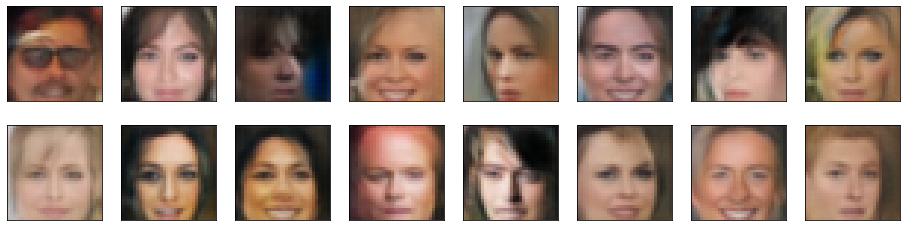

Epoch [   38/   50] | d_loss: 0.6334 | g_loss: 2.2292
Epoch [   38/   50] | d_loss: 1.2593 | g_loss: 1.9766
Epoch [   38/   50] | d_loss: 0.2971 | g_loss: 1.6715
Epoch [   38/   50] | d_loss: 0.9824 | g_loss: 1.8740
Epoch [   38/   50] | d_loss: 0.6183 | g_loss: 1.7267
Epoch [   38/   50] | d_loss: 0.5042 | g_loss: 1.9106
Epoch [   38/   50] | d_loss: 0.9226 | g_loss: 2.3556
Epoch [   38/   50] | d_loss: 0.3471 | g_loss: 1.5553
Epoch [   38/   50] | d_loss: 0.3162 | g_loss: 1.8860
Epoch [   38/   50] | d_loss: 0.5438 | g_loss: 2.3702
Epoch [   38/   50] | d_loss: 0.5597 | g_loss: 1.8196
Epoch [   38/   50] | d_loss: 0.6812 | g_loss: 1.5552
Epoch [   38/   50] | d_loss: 1.3740 | g_loss: 2.2994
Epoch [   38/   50] | d_loss: 0.5433 | g_loss: 1.4269
Epoch [   38/   50] | d_loss: 0.7434 | g_loss: 1.6499
Epoch [   38/   50] | d_loss: 0.8624 | g_loss: 1.4947
Epoch [   38/   50] | d_loss: 0.4164 | g_loss: 2.1119
Epoch [   38/   50] | d_loss: 0.7225 | g_loss: 1.2412
Epoch [   38/   50] | d_loss

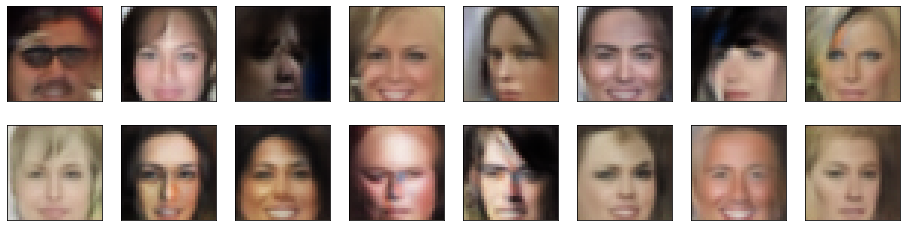

Epoch [   39/   50] | d_loss: 0.4439 | g_loss: 2.2341
Epoch [   39/   50] | d_loss: 0.2081 | g_loss: 2.0831
Epoch [   39/   50] | d_loss: 0.9301 | g_loss: 1.8213
Epoch [   39/   50] | d_loss: 0.2218 | g_loss: 1.7457
Epoch [   39/   50] | d_loss: 0.2864 | g_loss: 1.9814
Epoch [   39/   50] | d_loss: 0.7007 | g_loss: 2.0514
Epoch [   39/   50] | d_loss: 0.4898 | g_loss: 1.9182
Epoch [   39/   50] | d_loss: 1.0259 | g_loss: 2.1418
Epoch [   39/   50] | d_loss: 0.5321 | g_loss: 2.4244
Epoch [   39/   50] | d_loss: -0.0653 | g_loss: 1.0643
Epoch [   39/   50] | d_loss: 0.4300 | g_loss: 1.7742
Epoch [   39/   50] | d_loss: 0.7689 | g_loss: 2.3595
Epoch [   39/   50] | d_loss: 1.1376 | g_loss: 2.4983
Epoch [   39/   50] | d_loss: 0.5025 | g_loss: 1.7990
Epoch [   39/   50] | d_loss: 0.5869 | g_loss: 1.5101
Epoch [   39/   50] | d_loss: 0.3787 | g_loss: 1.4063
Epoch [   39/   50] | d_loss: 0.1740 | g_loss: 2.4472
Epoch [   39/   50] | d_loss: 1.0070 | g_loss: 1.3248
Epoch [   39/   50] | d_los

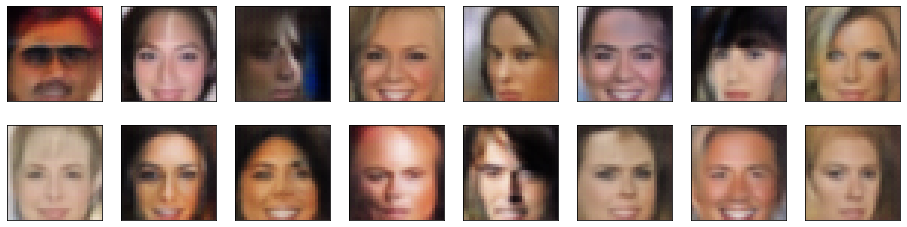

Epoch [   40/   50] | d_loss: 0.7090 | g_loss: 1.2162
Epoch [   40/   50] | d_loss: 0.6593 | g_loss: 2.2315
Epoch [   40/   50] | d_loss: 0.7442 | g_loss: 1.3103
Epoch [   40/   50] | d_loss: 0.0810 | g_loss: 1.9777
Epoch [   40/   50] | d_loss: 0.9185 | g_loss: 1.6634
Epoch [   40/   50] | d_loss: 0.8648 | g_loss: 1.7861
Epoch [   40/   50] | d_loss: 0.8896 | g_loss: 1.9143
Epoch [   40/   50] | d_loss: 0.8350 | g_loss: 1.5642
Epoch [   40/   50] | d_loss: 0.8134 | g_loss: 1.9648
Epoch [   40/   50] | d_loss: 0.5623 | g_loss: 1.2096
Epoch [   40/   50] | d_loss: 0.8393 | g_loss: 2.2695
Epoch [   40/   50] | d_loss: 0.3846 | g_loss: 1.8597
Epoch [   40/   50] | d_loss: 0.6899 | g_loss: 2.5325
Epoch [   40/   50] | d_loss: 0.2634 | g_loss: 1.6969
Epoch [   40/   50] | d_loss: 0.7273 | g_loss: 1.8255
Epoch [   40/   50] | d_loss: 1.0157 | g_loss: 2.3491
Epoch [   40/   50] | d_loss: 0.2010 | g_loss: 1.6457
Epoch [   40/   50] | d_loss: 0.5673 | g_loss: 1.7812
Epoch [   40/   50] | d_loss

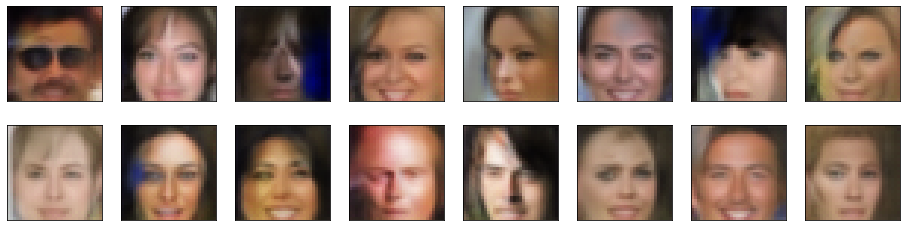

Epoch [   41/   50] | d_loss: 1.0568 | g_loss: 1.9413
Epoch [   41/   50] | d_loss: 0.9733 | g_loss: 2.0532
Epoch [   41/   50] | d_loss: 1.0088 | g_loss: 2.0018
Epoch [   41/   50] | d_loss: 1.1210 | g_loss: 1.1668
Epoch [   41/   50] | d_loss: 0.6105 | g_loss: 2.0205
Epoch [   41/   50] | d_loss: 0.4264 | g_loss: 1.5340
Epoch [   41/   50] | d_loss: 0.6785 | g_loss: 2.1155
Epoch [   41/   50] | d_loss: 0.5604 | g_loss: 1.7907
Epoch [   41/   50] | d_loss: 0.1278 | g_loss: 1.7597
Epoch [   41/   50] | d_loss: 0.8263 | g_loss: 2.3714
Epoch [   41/   50] | d_loss: 0.5458 | g_loss: 1.8259
Epoch [   41/   50] | d_loss: 0.8985 | g_loss: 1.8717
Epoch [   41/   50] | d_loss: 0.3226 | g_loss: 1.6692
Epoch [   41/   50] | d_loss: 0.7678 | g_loss: 1.8341
Epoch [   41/   50] | d_loss: 0.5656 | g_loss: 1.1878
Epoch [   41/   50] | d_loss: 0.8880 | g_loss: 2.3297
Epoch [   41/   50] | d_loss: 0.7996 | g_loss: 1.4850
Epoch [   41/   50] | d_loss: 0.2297 | g_loss: 1.4448
Epoch [   41/   50] | d_loss

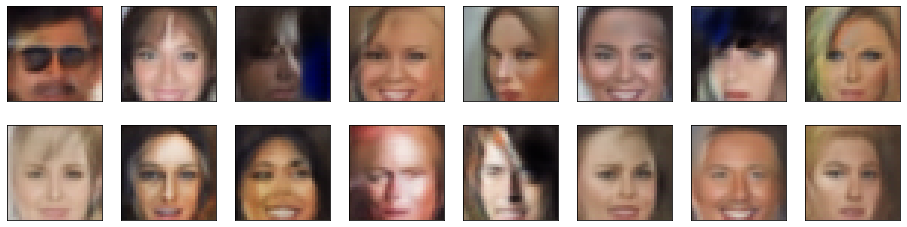

Epoch [   42/   50] | d_loss: 0.5955 | g_loss: 1.5817
Epoch [   42/   50] | d_loss: 0.4086 | g_loss: 1.6188
Epoch [   42/   50] | d_loss: 0.5805 | g_loss: 1.9172
Epoch [   42/   50] | d_loss: 0.8574 | g_loss: 2.1367
Epoch [   42/   50] | d_loss: 0.6119 | g_loss: 2.5560
Epoch [   42/   50] | d_loss: 1.0336 | g_loss: 2.2412
Epoch [   42/   50] | d_loss: 1.0655 | g_loss: 2.0899
Epoch [   42/   50] | d_loss: 0.9505 | g_loss: 1.5885
Epoch [   42/   50] | d_loss: 0.3781 | g_loss: 1.5550
Epoch [   42/   50] | d_loss: 1.3057 | g_loss: 1.7114
Epoch [   42/   50] | d_loss: 1.0470 | g_loss: 2.2115
Epoch [   42/   50] | d_loss: 0.6868 | g_loss: 1.1599
Epoch [   42/   50] | d_loss: 0.8036 | g_loss: 1.7308
Epoch [   42/   50] | d_loss: 0.8161 | g_loss: 1.7390
Epoch [   42/   50] | d_loss: 1.2180 | g_loss: 1.4669
Epoch [   42/   50] | d_loss: 0.4460 | g_loss: 1.5048
Epoch [   42/   50] | d_loss: 0.6698 | g_loss: 2.4941
Epoch [   42/   50] | d_loss: 0.5552 | g_loss: 1.8521
Epoch [   42/   50] | d_loss

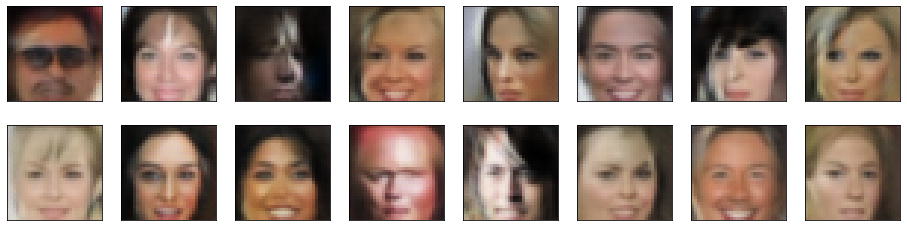

Epoch [   43/   50] | d_loss: 0.8845 | g_loss: 1.7518
Epoch [   43/   50] | d_loss: 0.3444 | g_loss: 2.2777
Epoch [   43/   50] | d_loss: 0.3528 | g_loss: 1.6409
Epoch [   43/   50] | d_loss: 1.0937 | g_loss: 1.9000
Epoch [   43/   50] | d_loss: 0.7132 | g_loss: 2.2388
Epoch [   43/   50] | d_loss: 1.0334 | g_loss: 1.9438
Epoch [   43/   50] | d_loss: 0.3512 | g_loss: 1.5849
Epoch [   43/   50] | d_loss: 0.1964 | g_loss: 2.1245
Epoch [   43/   50] | d_loss: 0.7073 | g_loss: 1.5908
Epoch [   43/   50] | d_loss: 0.4598 | g_loss: 2.0687
Epoch [   43/   50] | d_loss: 0.7828 | g_loss: 1.7108
Epoch [   43/   50] | d_loss: 0.8091 | g_loss: 2.0842
Epoch [   43/   50] | d_loss: 1.0709 | g_loss: 1.7719
Epoch [   43/   50] | d_loss: 0.8492 | g_loss: 1.8006
Epoch [   43/   50] | d_loss: 0.6937 | g_loss: 2.2671
Epoch [   43/   50] | d_loss: 0.9911 | g_loss: 1.9596
Epoch [   43/   50] | d_loss: 0.6871 | g_loss: 2.2289
Epoch [   43/   50] | d_loss: 0.8736 | g_loss: 1.1269
Epoch [   43/   50] | d_loss

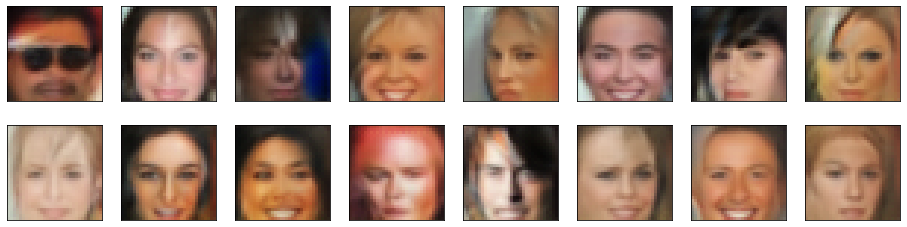

Epoch [   44/   50] | d_loss: 0.4637 | g_loss: 2.0902
Epoch [   44/   50] | d_loss: 1.1961 | g_loss: 1.5436
Epoch [   44/   50] | d_loss: 0.8785 | g_loss: 1.9241
Epoch [   44/   50] | d_loss: 1.3003 | g_loss: 1.9999
Epoch [   44/   50] | d_loss: 0.3149 | g_loss: 2.2859
Epoch [   44/   50] | d_loss: 0.9650 | g_loss: 1.6289
Epoch [   44/   50] | d_loss: 0.6211 | g_loss: 1.6943
Epoch [   44/   50] | d_loss: 0.3992 | g_loss: 1.5517
Epoch [   44/   50] | d_loss: 0.4342 | g_loss: 1.9636
Epoch [   44/   50] | d_loss: 1.0616 | g_loss: 1.9024
Epoch [   44/   50] | d_loss: 0.4389 | g_loss: 1.4226
Epoch [   44/   50] | d_loss: 0.7793 | g_loss: 1.9599
Epoch [   44/   50] | d_loss: 0.1027 | g_loss: 1.6196
Epoch [   44/   50] | d_loss: 0.7941 | g_loss: 1.6163
Epoch [   44/   50] | d_loss: 0.6332 | g_loss: 2.2549
Epoch [   44/   50] | d_loss: 0.4742 | g_loss: 2.1555
Epoch [   44/   50] | d_loss: 0.5465 | g_loss: 1.7757
Epoch [   44/   50] | d_loss: 1.0370 | g_loss: 1.9682
Epoch [   44/   50] | d_loss

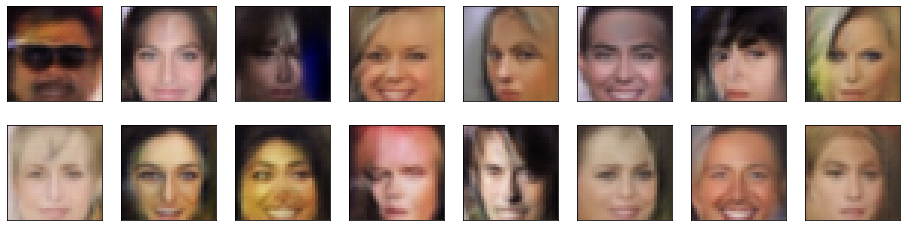

Epoch [   45/   50] | d_loss: 0.7748 | g_loss: 1.3301
Epoch [   45/   50] | d_loss: 0.3009 | g_loss: 1.8255
Epoch [   45/   50] | d_loss: 1.1187 | g_loss: 2.1810
Epoch [   45/   50] | d_loss: 0.4525 | g_loss: 2.1837
Epoch [   45/   50] | d_loss: 0.7630 | g_loss: 1.7983
Epoch [   45/   50] | d_loss: 0.0216 | g_loss: 1.4969
Epoch [   45/   50] | d_loss: 0.1828 | g_loss: 1.9232
Epoch [   45/   50] | d_loss: 0.7736 | g_loss: 1.9185
Epoch [   45/   50] | d_loss: 0.7053 | g_loss: 2.5512
Epoch [   45/   50] | d_loss: 0.1724 | g_loss: 1.4385
Epoch [   45/   50] | d_loss: 1.1915 | g_loss: 1.6230
Epoch [   45/   50] | d_loss: 0.3868 | g_loss: 1.5985
Epoch [   45/   50] | d_loss: 0.4016 | g_loss: 1.8665
Epoch [   45/   50] | d_loss: 0.7980 | g_loss: 1.3507
Epoch [   45/   50] | d_loss: 0.6796 | g_loss: 2.3042
Epoch [   45/   50] | d_loss: 0.1437 | g_loss: 1.9015
Epoch [   45/   50] | d_loss: 1.0042 | g_loss: 1.9007
Epoch [   45/   50] | d_loss: 0.5232 | g_loss: 2.3192
Epoch [   45/   50] | d_loss

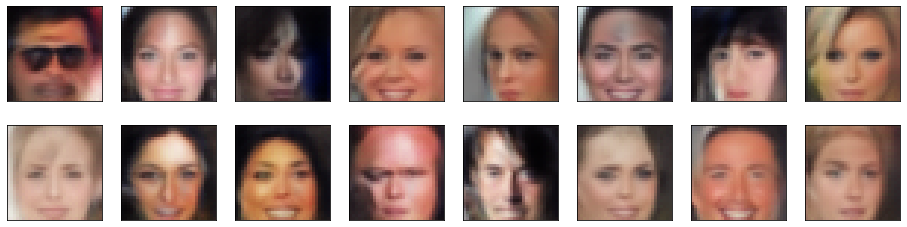

Epoch [   46/   50] | d_loss: 0.4815 | g_loss: 1.8224
Epoch [   46/   50] | d_loss: 0.9884 | g_loss: 0.9820
Epoch [   46/   50] | d_loss: 0.6685 | g_loss: 1.8284
Epoch [   46/   50] | d_loss: 0.4076 | g_loss: 2.0760
Epoch [   46/   50] | d_loss: 0.7717 | g_loss: 2.0815
Epoch [   46/   50] | d_loss: 0.2813 | g_loss: 1.1043
Epoch [   46/   50] | d_loss: 0.4595 | g_loss: 1.7080
Epoch [   46/   50] | d_loss: 0.8449 | g_loss: 2.0573
Epoch [   46/   50] | d_loss: 0.4552 | g_loss: 2.0044
Epoch [   46/   50] | d_loss: 0.5649 | g_loss: 1.7052
Epoch [   46/   50] | d_loss: 0.4191 | g_loss: 1.3466
Epoch [   46/   50] | d_loss: 1.3414 | g_loss: 1.7211
Epoch [   46/   50] | d_loss: 0.5922 | g_loss: 2.1883
Epoch [   46/   50] | d_loss: 0.7078 | g_loss: 1.7634
Epoch [   46/   50] | d_loss: 0.0758 | g_loss: 1.6322
Epoch [   46/   50] | d_loss: 0.3522 | g_loss: 1.2958
Epoch [   46/   50] | d_loss: 0.5290 | g_loss: 2.4571
Epoch [   46/   50] | d_loss: 0.8719 | g_loss: 1.6871
Epoch [   46/   50] | d_loss

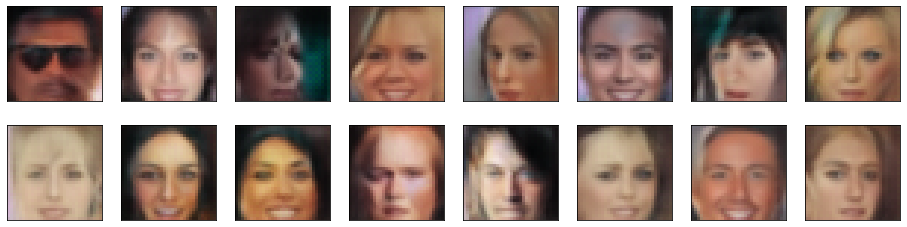

Epoch [   47/   50] | d_loss: 0.2871 | g_loss: 1.5308
Epoch [   47/   50] | d_loss: 0.4008 | g_loss: 1.9864
Epoch [   47/   50] | d_loss: 0.2633 | g_loss: 2.2133
Epoch [   47/   50] | d_loss: 0.4625 | g_loss: 1.6886
Epoch [   47/   50] | d_loss: 0.9375 | g_loss: 1.5754
Epoch [   47/   50] | d_loss: 1.1842 | g_loss: 2.0061
Epoch [   47/   50] | d_loss: 0.2490 | g_loss: 1.6573
Epoch [   47/   50] | d_loss: 0.5535 | g_loss: 1.4353
Epoch [   47/   50] | d_loss: 0.4836 | g_loss: 1.8411
Epoch [   47/   50] | d_loss: 0.8335 | g_loss: 1.9391
Epoch [   47/   50] | d_loss: 0.0938 | g_loss: 2.0451
Epoch [   47/   50] | d_loss: 0.1064 | g_loss: 2.2951
Epoch [   47/   50] | d_loss: 1.0682 | g_loss: 2.1837
Epoch [   47/   50] | d_loss: 0.0410 | g_loss: 1.3481
Epoch [   47/   50] | d_loss: 0.4167 | g_loss: 2.0432
Epoch [   47/   50] | d_loss: 0.3134 | g_loss: 1.8780
Epoch [   47/   50] | d_loss: -0.0624 | g_loss: 1.6915
Epoch [   47/   50] | d_loss: 0.6516 | g_loss: 2.2418
Epoch [   47/   50] | d_los

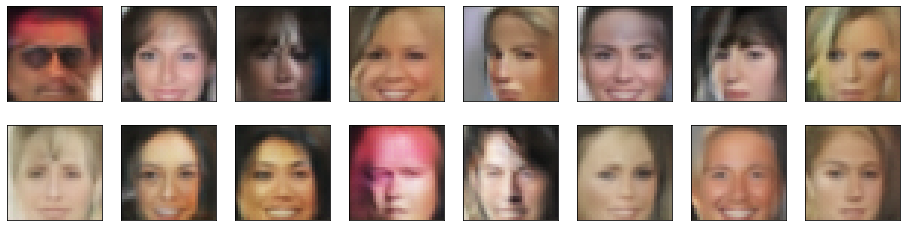

Epoch [   48/   50] | d_loss: 0.6368 | g_loss: 1.8515
Epoch [   48/   50] | d_loss: 0.5489 | g_loss: 1.9761
Epoch [   48/   50] | d_loss: 0.3330 | g_loss: 1.6179
Epoch [   48/   50] | d_loss: 0.1291 | g_loss: 1.7962
Epoch [   48/   50] | d_loss: 0.8658 | g_loss: 1.4145
Epoch [   48/   50] | d_loss: 1.0866 | g_loss: 1.7756
Epoch [   48/   50] | d_loss: 0.3920 | g_loss: 2.0125
Epoch [   48/   50] | d_loss: 1.1567 | g_loss: 1.9992
Epoch [   48/   50] | d_loss: 0.4643 | g_loss: 1.4123
Epoch [   48/   50] | d_loss: 0.2911 | g_loss: 2.0492
Epoch [   48/   50] | d_loss: 0.2690 | g_loss: 1.6111
Epoch [   48/   50] | d_loss: 0.9238 | g_loss: 1.7574
Epoch [   48/   50] | d_loss: 0.7038 | g_loss: 1.9222
Epoch [   48/   50] | d_loss: 0.8333 | g_loss: 1.5893
Epoch [   48/   50] | d_loss: 0.5573 | g_loss: 1.7699
Epoch [   48/   50] | d_loss: 0.5658 | g_loss: 2.0704
Epoch [   48/   50] | d_loss: 0.8874 | g_loss: 2.1695
Epoch [   48/   50] | d_loss: 0.1638 | g_loss: 2.3730
Epoch [   48/   50] | d_loss

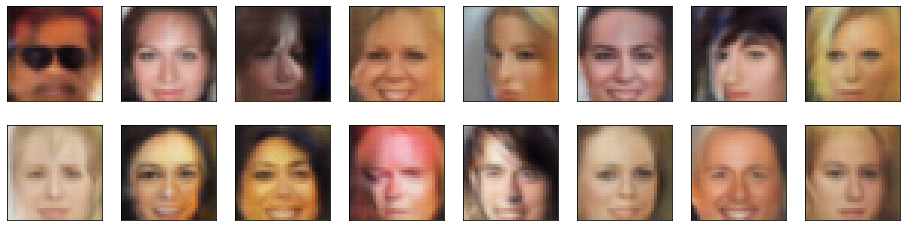

Epoch [   49/   50] | d_loss: 0.4577 | g_loss: 1.4875
Epoch [   49/   50] | d_loss: 0.7436 | g_loss: 2.0243
Epoch [   49/   50] | d_loss: 0.3309 | g_loss: 1.3531
Epoch [   49/   50] | d_loss: 0.8023 | g_loss: 1.5001
Epoch [   49/   50] | d_loss: 0.5393 | g_loss: 1.1819
Epoch [   49/   50] | d_loss: -0.1015 | g_loss: 2.1600
Epoch [   49/   50] | d_loss: 0.8838 | g_loss: 1.3928
Epoch [   49/   50] | d_loss: 0.8404 | g_loss: 1.7785
Epoch [   49/   50] | d_loss: 0.5820 | g_loss: 2.4041
Epoch [   49/   50] | d_loss: 0.4162 | g_loss: 1.9192
Epoch [   49/   50] | d_loss: 1.1611 | g_loss: 1.9364
Epoch [   49/   50] | d_loss: 1.2738 | g_loss: 1.9005
Epoch [   49/   50] | d_loss: 0.4001 | g_loss: 1.3163
Epoch [   49/   50] | d_loss: 0.7658 | g_loss: 1.5340
Epoch [   49/   50] | d_loss: 0.6442 | g_loss: 1.9664
Epoch [   49/   50] | d_loss: 0.7231 | g_loss: 2.4587
Epoch [   49/   50] | d_loss: 0.7398 | g_loss: 1.5354
Epoch [   49/   50] | d_loss: 1.0438 | g_loss: 1.7388
Epoch [   49/   50] | d_los

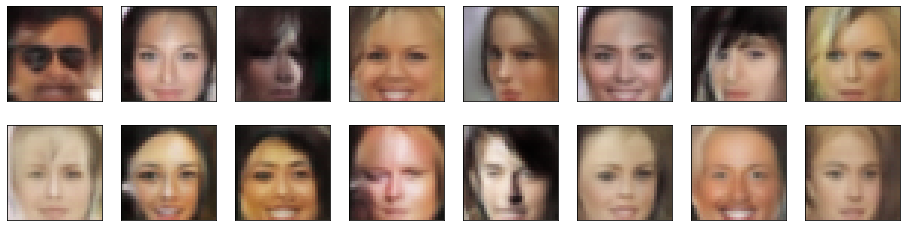

Epoch [   50/   50] | d_loss: 0.3226 | g_loss: 1.8746
Epoch [   50/   50] | d_loss: 0.7965 | g_loss: 2.2796
Epoch [   50/   50] | d_loss: 0.4748 | g_loss: 1.2106
Epoch [   50/   50] | d_loss: 0.9769 | g_loss: 1.9335
Epoch [   50/   50] | d_loss: 0.7444 | g_loss: 1.8289
Epoch [   50/   50] | d_loss: 0.3585 | g_loss: 2.1840
Epoch [   50/   50] | d_loss: 0.7003 | g_loss: 1.3415
Epoch [   50/   50] | d_loss: 0.5617 | g_loss: 1.8326
Epoch [   50/   50] | d_loss: 1.0414 | g_loss: 1.6382
Epoch [   50/   50] | d_loss: 0.6970 | g_loss: 1.4789
Epoch [   50/   50] | d_loss: 0.2949 | g_loss: 1.7925
Epoch [   50/   50] | d_loss: 0.9949 | g_loss: 1.9717
Epoch [   50/   50] | d_loss: 0.7119 | g_loss: 2.0590
Epoch [   50/   50] | d_loss: 0.7614 | g_loss: 1.8356
Epoch [   50/   50] | d_loss: 1.1359 | g_loss: 1.9079
Epoch [   50/   50] | d_loss: 0.5300 | g_loss: 2.0976
Epoch [   50/   50] | d_loss: 0.2856 | g_loss: 2.1152
Epoch [   50/   50] | d_loss: 0.7243 | g_loss: 1.3893
Epoch [   50/   50] | d_loss

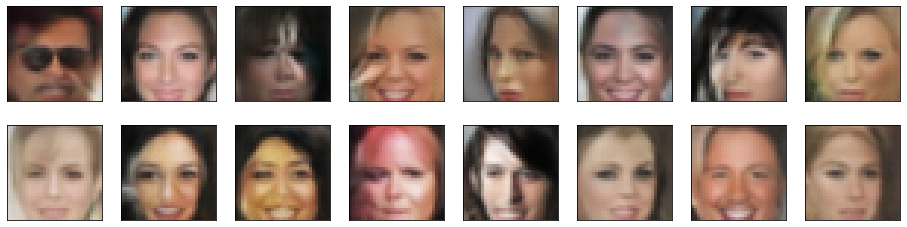

In [21]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

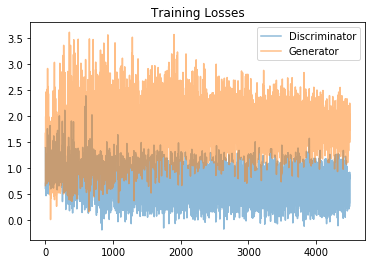

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

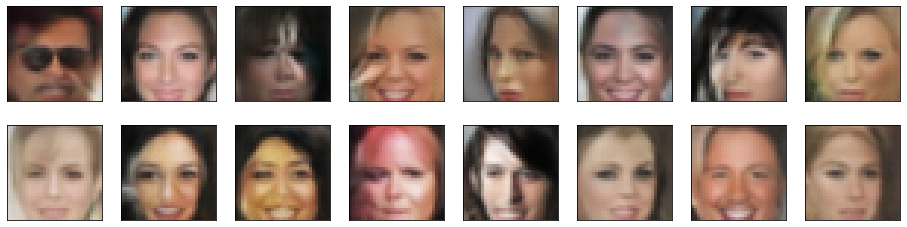

In [25]:
_ = view_samples(-1, samples)

# Higher Resolution model

This model will have a higher resolution, and for that an extra transposed convolutional layer is added in the Generator and another extra convolutional layer added in the Discriminator.

Moreover the depth of the conv/dconv are increased to 64.

### Discriminator

In [26]:
class Discriminator64(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # Input of 64x64
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 32x32
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 16x16
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 8x8
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 4x4
        
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.fc(out) # For some reason we end with a 50x1x1x1 tensor...
        return out

### Generator

In [27]:
class Generator64(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        # The first transpose conv layer should have a 4x4 size and depth of 512 = (4*32)
        self.fc = nn.Linear(z_size, conv_dim*4*4*8) 
        # The output of fc will be reshaped into a 4*4*512 vector
        # 4x4
        self.tconv1 = nn.ConvTranspose2d(conv_dim*8, conv_dim*4, 4, stride=2, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(conv_dim*2)
        # 8x8
        self.tconv2 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, stride=2, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(conv_dim)
        # 16x16
        self.tconv3 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(conv_dim)
        # 32x32
        self.tconv4 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1, bias=False)
        self.norm3 = nn.BatchNorm2d(conv_dim)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        # reshaping the vector to (batchsize, conv depth, 4size, 4size)
        out = out.view(-1, self.conv_dim*4, 4, 4) 
        
        out = F.relu(self.norm1(self.tconv1(out)))
        out = F.relu(self.norm2(self.tconv2(out)))
        out = self.tconv3(out)
        out = F.tanh(out)
        
        return out


In [28]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D64, G64 = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (tconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

In [29]:
# set number of epochs 
n_epochs = 50
n_epochs_decay = 10

In [30]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

d_optimizer = optim.Adam(D64.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G64.parameters(), lr, [beta1, beta2])


In [31]:
from torch.optim import lr_scheduler
# Learning rate policy
# Learning rate goes to 0 at the end of the number of 
def lambda_rule(epoch):
    lr_l = 1.0 - max(0, epoch - n_epochs) / float(n_epochs_decay + 1)
    return lr_l

d_scheduler = lr_scheduler.LambdaLR(d_optimizer, lr_lambda=lambda_rule)
g_scheduler = lr_scheduler.LambdaLR(g_optimizer, lr_lambda=lambda_rule)
schedulers = [d_scheduler, g_scheduler]

In [32]:
def update_learning_rate():
    """Update learning rates for all the networks; called at the end of every epoch"""
    for scheduler in schedulers:
        scheduler.step()
    lr = d_optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)

### Model 

In [33]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            # 1.1 Real images train
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            
            d_real_loss = real_loss(D_real)
            
            # 1.2 Fake images
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            
            D_fake = D(fake_images)
            
            # compute the fake loss
            d_fake_loss = fake_loss(D_fake)
            
            # final discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # 2.1 Train with
            # Generate fake img
            base_fake_img = np.random.uniform(-1, 1, size=(batch_size, z_size))
            base_fake_img = torch.from_numpy(base_fake_img).float()
            
            if train_on_gpu:
                base_fake_img = base_fake_img.cuda()
            
            fake_images = G(base_fake_img)
            D_fake = D(fake_images)
            
            # compute generator loss on fake img
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
            


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
    update_learning_rate()
    # Save training generator samples
    with open('train_samples64.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [34]:
losses = train(D64, G64, n_epochs=n_epochs+n_epochs_decay)

Epoch [    1/   60] | d_loss: 1.3988 | g_loss: 0.6632
Epoch [    1/   60] | d_loss: 0.9296 | g_loss: 1.9652
Epoch [    1/   60] | d_loss: 1.6503 | g_loss: 3.1272
Epoch [    1/   60] | d_loss: 0.6566 | g_loss: 1.7539
Epoch [    1/   60] | d_loss: 0.6686 | g_loss: 2.7675
Epoch [    1/   60] | d_loss: 0.7704 | g_loss: 1.3816
Epoch [    1/   60] | d_loss: 0.5956 | g_loss: 1.8536
Epoch [    1/   60] | d_loss: 0.5465 | g_loss: 1.6382
Epoch [    1/   60] | d_loss: 0.8206 | g_loss: 1.6760
Epoch [    1/   60] | d_loss: 0.8444 | g_loss: 2.0078
Epoch [    1/   60] | d_loss: 1.1699 | g_loss: 1.7065
Epoch [    1/   60] | d_loss: 0.8164 | g_loss: 3.1268
Epoch [    1/   60] | d_loss: 0.5166 | g_loss: 1.8089
Epoch [    1/   60] | d_loss: 1.0716 | g_loss: 1.4211
Epoch [    1/   60] | d_loss: 1.0866 | g_loss: 2.1397
Epoch [    1/   60] | d_loss: 1.1168 | g_loss: 1.7688
Epoch [    1/   60] | d_loss: 1.1431 | g_loss: 1.2885
Epoch [    1/   60] | d_loss: 1.1145 | g_loss: 1.2039
Epoch [    1/   60] | d_loss

Epoch [    2/   60] | d_loss: 0.8411 | g_loss: 1.6736
Epoch [    2/   60] | d_loss: 0.9804 | g_loss: 1.4624
Epoch [    2/   60] | d_loss: 0.8900 | g_loss: 1.0038
Epoch [    2/   60] | d_loss: 0.9644 | g_loss: 1.7635
Epoch [    2/   60] | d_loss: 1.0155 | g_loss: 2.4395
Epoch [    2/   60] | d_loss: 1.1292 | g_loss: 2.1885
Epoch [    2/   60] | d_loss: 0.9810 | g_loss: 1.1611
Epoch [    2/   60] | d_loss: 1.2386 | g_loss: 0.8476
Epoch [    2/   60] | d_loss: 0.8898 | g_loss: 1.1847
Epoch [    2/   60] | d_loss: 0.7154 | g_loss: 1.2136
Epoch [    2/   60] | d_loss: 1.1660 | g_loss: 2.2900
Epoch [    2/   60] | d_loss: 1.2676 | g_loss: 1.4395
Epoch [    2/   60] | d_loss: 0.7900 | g_loss: 0.7447
Epoch [    2/   60] | d_loss: 1.0564 | g_loss: 0.6185
Epoch [    2/   60] | d_loss: 1.2224 | g_loss: 1.6305
Epoch [    2/   60] | d_loss: 0.8948 | g_loss: 1.3358
Epoch [    2/   60] | d_loss: 1.1232 | g_loss: 1.4460
Epoch [    2/   60] | d_loss: 0.7037 | g_loss: 1.7950
Epoch [    2/   60] | d_loss

Epoch [    4/   60] | d_loss: 1.3745 | g_loss: 2.1992
Epoch [    4/   60] | d_loss: 0.8974 | g_loss: 0.9433
Epoch [    4/   60] | d_loss: 0.7628 | g_loss: 2.2285
Epoch [    4/   60] | d_loss: 1.0270 | g_loss: 1.9011
Epoch [    4/   60] | d_loss: 0.5874 | g_loss: 1.1753
Epoch [    4/   60] | d_loss: 1.3541 | g_loss: 0.7433
Epoch [    4/   60] | d_loss: 0.8872 | g_loss: 0.7040
Epoch [    4/   60] | d_loss: 1.2889 | g_loss: 2.0032
Epoch [    4/   60] | d_loss: 0.7572 | g_loss: 1.6238
Epoch [    4/   60] | d_loss: 0.5645 | g_loss: 0.6654
Epoch [    4/   60] | d_loss: 0.8489 | g_loss: 0.8543
Epoch [    4/   60] | d_loss: 0.6833 | g_loss: 1.8279
Epoch [    4/   60] | d_loss: 0.7205 | g_loss: 0.8398
Epoch [    4/   60] | d_loss: 0.8346 | g_loss: 2.2438
Epoch [    4/   60] | d_loss: 1.0557 | g_loss: 1.8998
Epoch [    4/   60] | d_loss: 1.5946 | g_loss: 1.6381
Epoch [    4/   60] | d_loss: 0.9154 | g_loss: 2.0343
Epoch [    4/   60] | d_loss: 0.8943 | g_loss: 1.4783
Epoch [    4/   60] | d_loss

Epoch [    6/   60] | d_loss: 0.4386 | g_loss: 1.4810
Epoch [    6/   60] | d_loss: 1.1473 | g_loss: 1.2140
Epoch [    6/   60] | d_loss: 0.9068 | g_loss: 2.6625
Epoch [    6/   60] | d_loss: 0.8534 | g_loss: 0.8313
Epoch [    6/   60] | d_loss: 0.9076 | g_loss: 2.8911
Epoch [    6/   60] | d_loss: 0.8277 | g_loss: 0.8779
Epoch [    6/   60] | d_loss: 0.6919 | g_loss: 1.1918
Epoch [    6/   60] | d_loss: 0.6776 | g_loss: 0.6582
Epoch [    6/   60] | d_loss: 0.5618 | g_loss: 1.1275
Epoch [    6/   60] | d_loss: 0.9592 | g_loss: 0.7486
Epoch [    6/   60] | d_loss: 0.4803 | g_loss: 2.3315
Epoch [    6/   60] | d_loss: 0.5710 | g_loss: 1.3559
Epoch [    6/   60] | d_loss: 0.7021 | g_loss: 1.1524
Epoch [    6/   60] | d_loss: 0.5390 | g_loss: 0.4456
Epoch [    6/   60] | d_loss: 1.0639 | g_loss: 1.1516
Epoch [    6/   60] | d_loss: 0.4343 | g_loss: 1.8928
Epoch [    6/   60] | d_loss: 0.6608 | g_loss: 0.6687
Epoch [    6/   60] | d_loss: 1.5166 | g_loss: 2.3583
Epoch [    6/   60] | d_loss

Epoch [    7/   60] | d_loss: 1.1489 | g_loss: 2.3415
Epoch [    7/   60] | d_loss: 0.6615 | g_loss: 1.9374
Epoch [    7/   60] | d_loss: 0.5917 | g_loss: 1.8653
Epoch [    7/   60] | d_loss: 0.6208 | g_loss: 2.8535
Epoch [    7/   60] | d_loss: 0.4352 | g_loss: 3.3353
Epoch [    7/   60] | d_loss: 0.9618 | g_loss: 1.8790
Epoch [    7/   60] | d_loss: 1.0905 | g_loss: 1.6756
Epoch [    7/   60] | d_loss: 1.1508 | g_loss: 1.5279
Epoch [    7/   60] | d_loss: 0.4774 | g_loss: 2.4034
Epoch [    7/   60] | d_loss: 0.2288 | g_loss: 1.0725
Epoch [    7/   60] | d_loss: 0.9721 | g_loss: 2.5538
Epoch [    7/   60] | d_loss: 1.3453 | g_loss: 1.1707
Epoch [    7/   60] | d_loss: 0.6180 | g_loss: 1.8077
Epoch [    7/   60] | d_loss: 0.2485 | g_loss: 1.8275
Epoch [    7/   60] | d_loss: 0.9972 | g_loss: 1.1846
Epoch [    7/   60] | d_loss: 1.1373 | g_loss: 0.9286
Epoch [    7/   60] | d_loss: 1.0605 | g_loss: 1.1625
Epoch [    7/   60] | d_loss: 0.7894 | g_loss: 1.2318
Epoch [    7/   60] | d_loss

Epoch [    9/   60] | d_loss: 0.8064 | g_loss: 1.2110
Epoch [    9/   60] | d_loss: 0.8336 | g_loss: 1.4337
Epoch [    9/   60] | d_loss: 1.3123 | g_loss: 1.8170
Epoch [    9/   60] | d_loss: 0.7784 | g_loss: 1.7376
Epoch [    9/   60] | d_loss: 0.3517 | g_loss: 2.1554
Epoch [    9/   60] | d_loss: 0.3421 | g_loss: 1.5359
Epoch [    9/   60] | d_loss: 1.2298 | g_loss: 1.9303
Epoch [    9/   60] | d_loss: 0.4179 | g_loss: 2.3149
Epoch [    9/   60] | d_loss: 0.6149 | g_loss: 2.2239
Epoch [    9/   60] | d_loss: 0.9291 | g_loss: 2.3630
Epoch [    9/   60] | d_loss: 0.5876 | g_loss: 2.1734
Epoch [    9/   60] | d_loss: 1.2420 | g_loss: 2.0285
Epoch [    9/   60] | d_loss: 0.7216 | g_loss: 1.6408
Epoch [    9/   60] | d_loss: 0.5599 | g_loss: 1.7576
Epoch [    9/   60] | d_loss: 0.5977 | g_loss: 1.1102
Epoch [    9/   60] | d_loss: 0.7069 | g_loss: 1.6910
Epoch [    9/   60] | d_loss: 0.6771 | g_loss: 1.8871
Epoch [    9/   60] | d_loss: 1.1033 | g_loss: 1.6126
Epoch [    9/   60] | d_loss

Epoch [   11/   60] | d_loss: 0.6357 | g_loss: 1.6141
Epoch [   11/   60] | d_loss: 0.4960 | g_loss: 1.5541
Epoch [   11/   60] | d_loss: 1.0366 | g_loss: 3.0492
Epoch [   11/   60] | d_loss: 0.8993 | g_loss: 2.1740
Epoch [   11/   60] | d_loss: 0.7065 | g_loss: 2.4572
Epoch [   11/   60] | d_loss: 0.2296 | g_loss: 2.1783
Epoch [   11/   60] | d_loss: 0.3925 | g_loss: 2.0418
Epoch [   11/   60] | d_loss: 0.3859 | g_loss: 2.1476
Epoch [   11/   60] | d_loss: 0.1047 | g_loss: 2.0590
Epoch [   11/   60] | d_loss: 0.5607 | g_loss: 1.6207
Epoch [   11/   60] | d_loss: 1.0663 | g_loss: 1.4384
Epoch [   11/   60] | d_loss: 0.4490 | g_loss: 0.5921
Epoch [   11/   60] | d_loss: 1.1551 | g_loss: 1.9878
Epoch [   11/   60] | d_loss: 0.4968 | g_loss: 3.1473
Epoch [   11/   60] | d_loss: 0.5561 | g_loss: 1.8055
Epoch [   11/   60] | d_loss: 0.6394 | g_loss: 2.0300
Epoch [   11/   60] | d_loss: 0.6533 | g_loss: 0.8293
Epoch [   11/   60] | d_loss: 0.7555 | g_loss: 1.0542
Epoch [   11/   60] | d_loss

Epoch [   12/   60] | d_loss: 1.1752 | g_loss: 1.5699
Epoch [   12/   60] | d_loss: 0.7736 | g_loss: 0.8141
Epoch [   12/   60] | d_loss: 0.8771 | g_loss: 2.7115
Epoch [   12/   60] | d_loss: 0.4794 | g_loss: 2.0865
Epoch [   12/   60] | d_loss: 0.7420 | g_loss: 1.1631
Epoch [   12/   60] | d_loss: 0.7957 | g_loss: 2.2134
Epoch [   12/   60] | d_loss: 0.4895 | g_loss: 2.4240
Epoch [   12/   60] | d_loss: 0.2430 | g_loss: 1.5749
Epoch [   12/   60] | d_loss: 0.8690 | g_loss: 1.7896
Epoch [   12/   60] | d_loss: 0.6407 | g_loss: 1.4754
Epoch [   12/   60] | d_loss: 1.0490 | g_loss: 1.3552
Epoch [   12/   60] | d_loss: 0.7571 | g_loss: 1.6976
Epoch [   12/   60] | d_loss: 0.8701 | g_loss: 1.9942
Epoch [   12/   60] | d_loss: 0.4561 | g_loss: 1.8492
Epoch [   12/   60] | d_loss: 0.6390 | g_loss: 1.7012
Epoch [   12/   60] | d_loss: 0.9174 | g_loss: 1.4646
Epoch [   12/   60] | d_loss: 0.2256 | g_loss: 1.8118
Epoch [   12/   60] | d_loss: 0.1807 | g_loss: 2.1556
Epoch [   12/   60] | d_loss

Epoch [   14/   60] | d_loss: 0.9678 | g_loss: 2.4898
Epoch [   14/   60] | d_loss: 0.6666 | g_loss: 1.3992
Epoch [   14/   60] | d_loss: 0.8556 | g_loss: 1.9644
Epoch [   14/   60] | d_loss: 1.1020 | g_loss: 1.6129
Epoch [   14/   60] | d_loss: 0.7903 | g_loss: 2.3283
Epoch [   14/   60] | d_loss: 1.1393 | g_loss: 2.2062
Epoch [   14/   60] | d_loss: 0.1461 | g_loss: 1.5791
Epoch [   14/   60] | d_loss: 0.4097 | g_loss: 1.1767
Epoch [   14/   60] | d_loss: 0.6012 | g_loss: 2.3752
Epoch [   14/   60] | d_loss: 1.7930 | g_loss: 1.8760
Epoch [   14/   60] | d_loss: 0.7558 | g_loss: 1.7849
Epoch [   14/   60] | d_loss: 0.9636 | g_loss: 2.2185
Epoch [   14/   60] | d_loss: 0.7935 | g_loss: 2.8612
Epoch [   14/   60] | d_loss: 0.9636 | g_loss: 1.8596
Epoch [   14/   60] | d_loss: 1.1028 | g_loss: 1.3957
Epoch [   14/   60] | d_loss: 1.0676 | g_loss: 1.3493
Epoch [   14/   60] | d_loss: 0.5789 | g_loss: 1.9461
Epoch [   14/   60] | d_loss: 0.6640 | g_loss: 1.9039
Epoch [   14/   60] | d_loss

Epoch [   16/   60] | d_loss: -0.1217 | g_loss: 0.9779
Epoch [   16/   60] | d_loss: 0.5299 | g_loss: 0.7591
Epoch [   16/   60] | d_loss: 0.5505 | g_loss: 1.7178
Epoch [   16/   60] | d_loss: 0.9351 | g_loss: 1.6613
Epoch [   16/   60] | d_loss: 0.6001 | g_loss: 1.6503
Epoch [   16/   60] | d_loss: 0.4032 | g_loss: 0.7026
Epoch [   16/   60] | d_loss: 0.9407 | g_loss: 1.8485
Epoch [   16/   60] | d_loss: 0.7691 | g_loss: 2.0508
Epoch [   16/   60] | d_loss: 0.0499 | g_loss: 1.7964
Epoch [   16/   60] | d_loss: 0.2898 | g_loss: 1.6804
Epoch [   16/   60] | d_loss: 1.0843 | g_loss: 2.1173
Epoch [   16/   60] | d_loss: 0.4997 | g_loss: 1.7381
Epoch [   16/   60] | d_loss: 0.7520 | g_loss: 1.7968
Epoch [   16/   60] | d_loss: 1.0914 | g_loss: 1.7226
Epoch [   16/   60] | d_loss: 0.8352 | g_loss: 1.5315
Epoch [   16/   60] | d_loss: 0.6088 | g_loss: 1.2547
Epoch [   16/   60] | d_loss: 0.5968 | g_loss: 2.1971
Epoch [   16/   60] | d_loss: 0.7179 | g_loss: 2.9251
Epoch [   16/   60] | d_los

Epoch [   17/   60] | d_loss: 0.2041 | g_loss: 1.6075
Epoch [   17/   60] | d_loss: 0.5335 | g_loss: 1.5743
Epoch [   17/   60] | d_loss: 0.8142 | g_loss: 1.8466
Epoch [   17/   60] | d_loss: 0.3642 | g_loss: 1.6384
Epoch [   17/   60] | d_loss: 0.5948 | g_loss: 1.9391
Epoch [   17/   60] | d_loss: 0.6680 | g_loss: 2.3154
Epoch [   17/   60] | d_loss: 0.7313 | g_loss: 1.5975
Epoch [   17/   60] | d_loss: 0.8173 | g_loss: 1.9899
Epoch [   17/   60] | d_loss: 1.0199 | g_loss: 2.2541
Epoch [   17/   60] | d_loss: 1.3096 | g_loss: 0.9395
Epoch [   17/   60] | d_loss: 0.8076 | g_loss: 1.8546
Epoch [   17/   60] | d_loss: 0.5699 | g_loss: 0.9232
Epoch [   17/   60] | d_loss: 0.5371 | g_loss: 2.7031
Epoch [   17/   60] | d_loss: 0.9762 | g_loss: 1.3626
Epoch [   17/   60] | d_loss: 0.8562 | g_loss: 2.2116
Epoch [   17/   60] | d_loss: 1.0311 | g_loss: 1.8865
Epoch [   17/   60] | d_loss: 0.5508 | g_loss: 1.8379
Epoch [   17/   60] | d_loss: 0.5399 | g_loss: 1.8188
Epoch [   17/   60] | d_loss

Epoch [   19/   60] | d_loss: 0.8185 | g_loss: 1.6398
Epoch [   19/   60] | d_loss: 0.8221 | g_loss: 1.7254
Epoch [   19/   60] | d_loss: 0.7528 | g_loss: 1.5847
Epoch [   19/   60] | d_loss: 0.6807 | g_loss: 2.1112
Epoch [   19/   60] | d_loss: 1.2461 | g_loss: 1.9240
Epoch [   19/   60] | d_loss: 1.3900 | g_loss: 2.3365
Epoch [   19/   60] | d_loss: 0.1143 | g_loss: 2.1937
Epoch [   19/   60] | d_loss: 0.7211 | g_loss: 2.3099
Epoch [   19/   60] | d_loss: 0.7747 | g_loss: 1.4787
Epoch [   19/   60] | d_loss: 1.2595 | g_loss: 1.6590
Epoch [   19/   60] | d_loss: 1.1792 | g_loss: 2.6811
Epoch [   19/   60] | d_loss: 0.6259 | g_loss: 2.0607
Epoch [   19/   60] | d_loss: 0.1564 | g_loss: 1.5460
Epoch [   19/   60] | d_loss: 0.6992 | g_loss: 1.6612
Epoch [   19/   60] | d_loss: 0.4920 | g_loss: 0.9930
Epoch [   19/   60] | d_loss: 0.8837 | g_loss: 1.9717
Epoch [   19/   60] | d_loss: 1.0503 | g_loss: 2.3788
Epoch [   19/   60] | d_loss: 0.3497 | g_loss: 1.2609
Epoch [   19/   60] | d_loss

Epoch [   21/   60] | d_loss: 0.5633 | g_loss: 2.3137
Epoch [   21/   60] | d_loss: 0.9090 | g_loss: 1.2676
Epoch [   21/   60] | d_loss: 1.2244 | g_loss: 2.4540
Epoch [   21/   60] | d_loss: 0.7831 | g_loss: 1.4684
Epoch [   21/   60] | d_loss: 0.8402 | g_loss: 2.2605
Epoch [   21/   60] | d_loss: 0.9101 | g_loss: 2.4652
Epoch [   21/   60] | d_loss: 0.3616 | g_loss: 2.0051
Epoch [   21/   60] | d_loss: 0.7680 | g_loss: 2.2268
Epoch [   21/   60] | d_loss: 1.0684 | g_loss: 2.8047
Epoch [   21/   60] | d_loss: 0.6575 | g_loss: 1.3149
Epoch [   21/   60] | d_loss: 0.5638 | g_loss: 2.0786
Epoch [   21/   60] | d_loss: 0.4450 | g_loss: 1.8136
Epoch [   21/   60] | d_loss: 0.5240 | g_loss: 1.4797
Epoch [   21/   60] | d_loss: 0.5930 | g_loss: 1.3834
Epoch [   21/   60] | d_loss: 0.7932 | g_loss: 0.8168
Epoch [   21/   60] | d_loss: 1.0722 | g_loss: 1.7090
Epoch [   21/   60] | d_loss: 0.8675 | g_loss: 1.7447
Epoch [   21/   60] | d_loss: 0.2786 | g_loss: 1.6766
Epoch [   21/   60] | d_loss

Epoch [   22/   60] | d_loss: 0.5885 | g_loss: 1.9710
Epoch [   22/   60] | d_loss: 0.4052 | g_loss: 2.4565
Epoch [   22/   60] | d_loss: 1.2212 | g_loss: 0.9001
Epoch [   22/   60] | d_loss: 0.5511 | g_loss: 1.8214
Epoch [   22/   60] | d_loss: 0.1794 | g_loss: 1.6917
Epoch [   22/   60] | d_loss: 0.3048 | g_loss: 1.7465
Epoch [   22/   60] | d_loss: 0.7015 | g_loss: 3.1382
Epoch [   22/   60] | d_loss: 0.7491 | g_loss: 2.2376
Epoch [   22/   60] | d_loss: 0.3308 | g_loss: 1.3819
Epoch [   22/   60] | d_loss: 0.5991 | g_loss: 1.3224
Epoch [   22/   60] | d_loss: 0.5775 | g_loss: 1.5864
Epoch [   22/   60] | d_loss: 0.7991 | g_loss: 1.4341
Epoch [   22/   60] | d_loss: 0.8105 | g_loss: 1.9068
Epoch [   22/   60] | d_loss: 0.4729 | g_loss: 1.8887
Epoch [   22/   60] | d_loss: 0.8408 | g_loss: 1.8073
Epoch [   22/   60] | d_loss: 0.7673 | g_loss: 2.3904
Epoch [   22/   60] | d_loss: 0.1990 | g_loss: 2.2201
Epoch [   23/   60] | d_loss: 0.8591 | g_loss: 1.2680
Epoch [   23/   60] | d_loss

Epoch [   24/   60] | d_loss: 0.5291 | g_loss: 1.3487
Epoch [   24/   60] | d_loss: 0.2981 | g_loss: 1.0109
Epoch [   24/   60] | d_loss: 0.5537 | g_loss: 2.2533
Epoch [   24/   60] | d_loss: 1.2826 | g_loss: 2.3455
Epoch [   24/   60] | d_loss: 0.6877 | g_loss: 1.4615
Epoch [   24/   60] | d_loss: 0.6360 | g_loss: 1.7681
Epoch [   24/   60] | d_loss: 1.1341 | g_loss: 2.2844
Epoch [   24/   60] | d_loss: 0.6588 | g_loss: 1.4650
Epoch [   24/   60] | d_loss: 0.2149 | g_loss: 0.9860
Epoch [   24/   60] | d_loss: 0.9248 | g_loss: 2.0598
Epoch [   24/   60] | d_loss: 0.4402 | g_loss: 1.8926
Epoch [   24/   60] | d_loss: 0.7366 | g_loss: 2.3220
Epoch [   24/   60] | d_loss: 0.4867 | g_loss: 1.7491
Epoch [   24/   60] | d_loss: 0.8338 | g_loss: 1.5102
Epoch [   24/   60] | d_loss: 0.7389 | g_loss: 2.5632
Epoch [   24/   60] | d_loss: 1.0011 | g_loss: 1.9600
Epoch [   24/   60] | d_loss: 0.8431 | g_loss: 1.6589
Epoch [   24/   60] | d_loss: 0.8673 | g_loss: 2.1417
Epoch [   24/   60] | d_loss

Epoch [   26/   60] | d_loss: 0.6645 | g_loss: 1.4220
Epoch [   26/   60] | d_loss: 0.9573 | g_loss: 2.1907
Epoch [   26/   60] | d_loss: 0.6129 | g_loss: 2.4111
Epoch [   26/   60] | d_loss: 0.2902 | g_loss: 2.0152
Epoch [   26/   60] | d_loss: 0.4925 | g_loss: 2.0971
Epoch [   26/   60] | d_loss: 0.8716 | g_loss: 1.5419
Epoch [   26/   60] | d_loss: 0.7725 | g_loss: 1.6317
Epoch [   26/   60] | d_loss: 0.6253 | g_loss: 0.9154
Epoch [   26/   60] | d_loss: 0.7517 | g_loss: 2.5958
Epoch [   26/   60] | d_loss: 0.5474 | g_loss: 1.5948
Epoch [   26/   60] | d_loss: 0.3567 | g_loss: 2.0173
Epoch [   26/   60] | d_loss: 0.3432 | g_loss: 1.5936
Epoch [   26/   60] | d_loss: 1.1630 | g_loss: 1.8530
Epoch [   26/   60] | d_loss: 0.3233 | g_loss: 2.0646
Epoch [   26/   60] | d_loss: 0.0267 | g_loss: 1.5370
Epoch [   26/   60] | d_loss: 0.3827 | g_loss: 1.4988
Epoch [   26/   60] | d_loss: 0.8272 | g_loss: 2.3667
Epoch [   26/   60] | d_loss: 1.1719 | g_loss: 1.5858
Epoch [   26/   60] | d_loss

Epoch [   27/   60] | d_loss: 0.6914 | g_loss: 2.1050
Epoch [   27/   60] | d_loss: 0.9739 | g_loss: 1.8245
Epoch [   27/   60] | d_loss: 0.8770 | g_loss: 1.6736
Epoch [   27/   60] | d_loss: 0.7743 | g_loss: 1.7075
Epoch [   27/   60] | d_loss: 0.9370 | g_loss: 0.7798
Epoch [   27/   60] | d_loss: 0.9445 | g_loss: 1.5064
Epoch [   27/   60] | d_loss: 0.9062 | g_loss: 2.0799
Epoch [   27/   60] | d_loss: 0.9287 | g_loss: 2.3445
Epoch [   27/   60] | d_loss: 0.6375 | g_loss: 2.8210
Epoch [   27/   60] | d_loss: 0.6899 | g_loss: 1.5355
Epoch [   27/   60] | d_loss: 0.7475 | g_loss: 2.5258
Epoch [   27/   60] | d_loss: 0.9564 | g_loss: 2.2177
Epoch [   27/   60] | d_loss: 0.9323 | g_loss: 1.9985
Epoch [   27/   60] | d_loss: 0.1223 | g_loss: 1.9142
Epoch [   28/   60] | d_loss: 0.9301 | g_loss: 1.3660
Epoch [   28/   60] | d_loss: 0.7460 | g_loss: 0.9090
Epoch [   28/   60] | d_loss: 0.8105 | g_loss: 1.5374
Epoch [   28/   60] | d_loss: 0.7342 | g_loss: 2.1106
Epoch [   28/   60] | d_loss

Epoch [   29/   60] | d_loss: 1.0195 | g_loss: 1.9707
Epoch [   29/   60] | d_loss: 0.8316 | g_loss: 1.5164
Epoch [   29/   60] | d_loss: 0.7503 | g_loss: 1.7437
Epoch [   29/   60] | d_loss: 0.4773 | g_loss: 1.9879
Epoch [   29/   60] | d_loss: 0.9343 | g_loss: 2.0430
Epoch [   29/   60] | d_loss: 0.6293 | g_loss: 2.1809
Epoch [   29/   60] | d_loss: 0.7769 | g_loss: 2.1401
Epoch [   29/   60] | d_loss: 1.1722 | g_loss: 1.6528
Epoch [   29/   60] | d_loss: 1.0981 | g_loss: 1.5876
Epoch [   29/   60] | d_loss: 0.9636 | g_loss: 1.4975
Epoch [   29/   60] | d_loss: 0.2115 | g_loss: 1.7014
Epoch [   29/   60] | d_loss: 0.8082 | g_loss: 1.4443
Epoch [   29/   60] | d_loss: 0.4399 | g_loss: 1.6831
Epoch [   29/   60] | d_loss: 0.6286 | g_loss: 1.9348
Epoch [   29/   60] | d_loss: 1.1682 | g_loss: 2.1034
Epoch [   29/   60] | d_loss: 0.4039 | g_loss: 2.1424
Epoch [   29/   60] | d_loss: 0.2873 | g_loss: 1.8936
Epoch [   29/   60] | d_loss: 0.1867 | g_loss: 1.6516
Epoch [   29/   60] | d_loss

Epoch [   31/   60] | d_loss: 0.7189 | g_loss: 2.0897
Epoch [   31/   60] | d_loss: 1.2091 | g_loss: 1.8905
Epoch [   31/   60] | d_loss: 0.6782 | g_loss: 2.0601
Epoch [   31/   60] | d_loss: 0.6055 | g_loss: 2.0638
Epoch [   31/   60] | d_loss: 0.5069 | g_loss: 2.0982
Epoch [   31/   60] | d_loss: 1.0323 | g_loss: 2.2117
Epoch [   31/   60] | d_loss: 0.9233 | g_loss: 2.1456
Epoch [   31/   60] | d_loss: 0.4181 | g_loss: 1.6687
Epoch [   31/   60] | d_loss: 0.4336 | g_loss: 2.0565
Epoch [   31/   60] | d_loss: 0.7649 | g_loss: 1.6262
Epoch [   31/   60] | d_loss: 0.3572 | g_loss: 2.3144
Epoch [   31/   60] | d_loss: 0.4837 | g_loss: 2.1272
Epoch [   31/   60] | d_loss: 0.2140 | g_loss: 2.0156
Epoch [   31/   60] | d_loss: 0.2392 | g_loss: 2.5965
Epoch [   31/   60] | d_loss: 0.5854 | g_loss: 1.4575
Epoch [   31/   60] | d_loss: 0.6712 | g_loss: 1.3770
Epoch [   31/   60] | d_loss: 0.7081 | g_loss: 1.6075
Epoch [   31/   60] | d_loss: 0.0605 | g_loss: 1.5028
Epoch [   31/   60] | d_loss

Epoch [   32/   60] | d_loss: 1.1024 | g_loss: 2.0929
Epoch [   32/   60] | d_loss: 1.1439 | g_loss: 1.2873
Epoch [   32/   60] | d_loss: 0.7551 | g_loss: 2.2161
Epoch [   32/   60] | d_loss: 0.3842 | g_loss: 1.4760
Epoch [   32/   60] | d_loss: 1.0680 | g_loss: 1.9778
Epoch [   32/   60] | d_loss: 0.9597 | g_loss: 1.7895
Epoch [   32/   60] | d_loss: 0.9520 | g_loss: 1.3918
Epoch [   32/   60] | d_loss: 0.3098 | g_loss: 1.7276
Epoch [   32/   60] | d_loss: 0.3164 | g_loss: 1.7346
Epoch [   32/   60] | d_loss: 0.5233 | g_loss: 2.3805
Epoch [   32/   60] | d_loss: 0.6255 | g_loss: 1.9429
Epoch [   33/   60] | d_loss: 0.9132 | g_loss: 1.7808
Epoch [   33/   60] | d_loss: 0.4365 | g_loss: 1.9069
Epoch [   33/   60] | d_loss: 0.4778 | g_loss: 2.3047
Epoch [   33/   60] | d_loss: 0.5443 | g_loss: 1.6629
Epoch [   33/   60] | d_loss: 0.7039 | g_loss: 1.7984
Epoch [   33/   60] | d_loss: 0.5421 | g_loss: 1.0763
Epoch [   33/   60] | d_loss: 0.3877 | g_loss: 1.8210
Epoch [   33/   60] | d_loss

Epoch [   34/   60] | d_loss: 0.8863 | g_loss: 1.5687
Epoch [   34/   60] | d_loss: 0.1348 | g_loss: 1.6785
Epoch [   34/   60] | d_loss: 0.2260 | g_loss: 1.5927
Epoch [   34/   60] | d_loss: 0.5830 | g_loss: 1.1393
Epoch [   34/   60] | d_loss: 0.5354 | g_loss: 2.0178
Epoch [   34/   60] | d_loss: 0.1806 | g_loss: 2.1480
Epoch [   34/   60] | d_loss: 0.8529 | g_loss: 1.1032
Epoch [   34/   60] | d_loss: 0.8919 | g_loss: 1.4026
Epoch [   34/   60] | d_loss: 0.4297 | g_loss: 1.8329
Epoch [   34/   60] | d_loss: 0.6693 | g_loss: 1.6180
Epoch [   34/   60] | d_loss: 0.3086 | g_loss: 1.1667
Epoch [   34/   60] | d_loss: 1.1925 | g_loss: 1.3546
Epoch [   34/   60] | d_loss: 1.1056 | g_loss: 2.0177
Epoch [   34/   60] | d_loss: 0.4451 | g_loss: 1.8452
Epoch [   34/   60] | d_loss: 0.4549 | g_loss: 1.7277
Epoch [   34/   60] | d_loss: 0.3039 | g_loss: 1.7783
Epoch [   34/   60] | d_loss: 0.3321 | g_loss: 1.6820
Epoch [   34/   60] | d_loss: 1.0566 | g_loss: 2.3192
Epoch [   34/   60] | d_loss

Epoch [   36/   60] | d_loss: 0.7199 | g_loss: 1.6517
Epoch [   36/   60] | d_loss: 0.3739 | g_loss: 1.7554
Epoch [   36/   60] | d_loss: 0.6294 | g_loss: 2.4414
Epoch [   36/   60] | d_loss: 0.6280 | g_loss: 1.5013
Epoch [   36/   60] | d_loss: 0.9942 | g_loss: 1.8170
Epoch [   36/   60] | d_loss: 0.5319 | g_loss: 2.1026
Epoch [   36/   60] | d_loss: 1.0253 | g_loss: 1.8895
Epoch [   36/   60] | d_loss: 0.2849 | g_loss: 1.7332
Epoch [   36/   60] | d_loss: 0.5108 | g_loss: 2.0136
Epoch [   36/   60] | d_loss: 0.3214 | g_loss: 1.5836
Epoch [   36/   60] | d_loss: 0.3693 | g_loss: 1.9210
Epoch [   36/   60] | d_loss: 0.8138 | g_loss: 2.8103
Epoch [   36/   60] | d_loss: 0.1508 | g_loss: 1.6058
Epoch [   36/   60] | d_loss: 0.5357 | g_loss: 2.0238
Epoch [   36/   60] | d_loss: 1.1177 | g_loss: 1.8629
Epoch [   36/   60] | d_loss: 0.7759 | g_loss: 1.8442
Epoch [   36/   60] | d_loss: 0.5190 | g_loss: 2.0443
Epoch [   36/   60] | d_loss: 0.9532 | g_loss: 1.2577
Epoch [   36/   60] | d_loss

Epoch [   37/   60] | d_loss: 0.6185 | g_loss: 1.8603
Epoch [   37/   60] | d_loss: 0.5837 | g_loss: 1.4410
Epoch [   37/   60] | d_loss: 0.5019 | g_loss: 1.3799
Epoch [   37/   60] | d_loss: 0.6844 | g_loss: 1.8646
Epoch [   37/   60] | d_loss: 0.2625 | g_loss: 1.5209
Epoch [   37/   60] | d_loss: 0.2201 | g_loss: 1.6688
Epoch [   37/   60] | d_loss: 0.6216 | g_loss: 2.0040
Epoch [   37/   60] | d_loss: 0.1467 | g_loss: 1.5978
Epoch [   38/   60] | d_loss: 1.6115 | g_loss: 2.4653
Epoch [   38/   60] | d_loss: 0.4256 | g_loss: 2.4434
Epoch [   38/   60] | d_loss: 0.7887 | g_loss: 1.7165
Epoch [   38/   60] | d_loss: 0.6237 | g_loss: 2.0989
Epoch [   38/   60] | d_loss: 0.9395 | g_loss: 1.6442
Epoch [   38/   60] | d_loss: 0.4767 | g_loss: 1.4758
Epoch [   38/   60] | d_loss: 0.5003 | g_loss: 2.2697
Epoch [   38/   60] | d_loss: 0.1437 | g_loss: 1.6857
Epoch [   38/   60] | d_loss: 0.6056 | g_loss: 1.7703
Epoch [   38/   60] | d_loss: 0.5097 | g_loss: 1.9976
Epoch [   38/   60] | d_loss

Epoch [   39/   60] | d_loss: 0.6598 | g_loss: 1.9006
Epoch [   39/   60] | d_loss: 0.7464 | g_loss: 1.9831
Epoch [   39/   60] | d_loss: 0.4000 | g_loss: 1.9576
Epoch [   39/   60] | d_loss: 0.9076 | g_loss: 1.3386
Epoch [   39/   60] | d_loss: 0.8311 | g_loss: 1.6606
Epoch [   39/   60] | d_loss: 0.7657 | g_loss: 1.9311
Epoch [   39/   60] | d_loss: 0.3299 | g_loss: 1.3538
Epoch [   39/   60] | d_loss: 0.3256 | g_loss: 1.9859
Epoch [   39/   60] | d_loss: 0.9279 | g_loss: 1.7808
Epoch [   39/   60] | d_loss: 0.8299 | g_loss: 2.1898
Epoch [   39/   60] | d_loss: 1.1538 | g_loss: 1.4601
Epoch [   39/   60] | d_loss: 0.2381 | g_loss: 1.7374
Epoch [   39/   60] | d_loss: 0.4569 | g_loss: 1.4920
Epoch [   39/   60] | d_loss: 0.7168 | g_loss: 1.7099
Epoch [   39/   60] | d_loss: 0.2350 | g_loss: 1.5240
Epoch [   39/   60] | d_loss: 0.3353 | g_loss: 1.8278
Epoch [   39/   60] | d_loss: 0.9774 | g_loss: 2.3399
Epoch [   39/   60] | d_loss: 0.5932 | g_loss: 2.3073
Epoch [   39/   60] | d_loss

Epoch [   41/   60] | d_loss: 0.5420 | g_loss: 1.6051
Epoch [   41/   60] | d_loss: 0.7721 | g_loss: 2.3382
Epoch [   41/   60] | d_loss: 0.3177 | g_loss: 2.5806
Epoch [   41/   60] | d_loss: 1.0457 | g_loss: 1.6891
Epoch [   41/   60] | d_loss: 0.3688 | g_loss: 1.6448
Epoch [   41/   60] | d_loss: 0.9389 | g_loss: 2.0697
Epoch [   41/   60] | d_loss: 0.8909 | g_loss: 1.9600
Epoch [   41/   60] | d_loss: 0.8817 | g_loss: 1.2015
Epoch [   41/   60] | d_loss: 0.0837 | g_loss: 1.6830
Epoch [   41/   60] | d_loss: 1.1790 | g_loss: 1.3615
Epoch [   41/   60] | d_loss: 0.4090 | g_loss: 1.3538
Epoch [   41/   60] | d_loss: 0.2388 | g_loss: 1.3862
Epoch [   41/   60] | d_loss: 0.4987 | g_loss: 1.6023
Epoch [   41/   60] | d_loss: 0.4324 | g_loss: 1.8845
Epoch [   41/   60] | d_loss: 0.4332 | g_loss: 1.7138
Epoch [   41/   60] | d_loss: 0.5304 | g_loss: 2.0828
Epoch [   41/   60] | d_loss: 0.8141 | g_loss: 1.8757
Epoch [   41/   60] | d_loss: 0.1954 | g_loss: 1.9626
Epoch [   41/   60] | d_loss

Epoch [   42/   60] | d_loss: 0.9099 | g_loss: 1.4598
Epoch [   42/   60] | d_loss: 0.4995 | g_loss: 1.9512
Epoch [   42/   60] | d_loss: 1.3503 | g_loss: 1.2553
Epoch [   42/   60] | d_loss: 0.6122 | g_loss: 1.8234
Epoch [   42/   60] | d_loss: 0.7764 | g_loss: 2.2572
Epoch [   43/   60] | d_loss: 0.6507 | g_loss: 1.7812
Epoch [   43/   60] | d_loss: 0.6284 | g_loss: 1.1248
Epoch [   43/   60] | d_loss: 1.1655 | g_loss: 2.1608
Epoch [   43/   60] | d_loss: 0.9707 | g_loss: 2.0946
Epoch [   43/   60] | d_loss: 0.1943 | g_loss: 2.1548
Epoch [   43/   60] | d_loss: 1.0703 | g_loss: 1.8040
Epoch [   43/   60] | d_loss: 0.4126 | g_loss: 1.5715
Epoch [   43/   60] | d_loss: 0.2179 | g_loss: 1.7118
Epoch [   43/   60] | d_loss: 1.0029 | g_loss: 2.0101
Epoch [   43/   60] | d_loss: 0.1179 | g_loss: 1.6214
Epoch [   43/   60] | d_loss: 0.6911 | g_loss: 2.1187
Epoch [   43/   60] | d_loss: 0.7414 | g_loss: 2.1998
Epoch [   43/   60] | d_loss: 0.7410 | g_loss: 1.4286
Epoch [   43/   60] | d_loss

Epoch [   44/   60] | d_loss: 0.9198 | g_loss: 1.9208
Epoch [   44/   60] | d_loss: 1.3062 | g_loss: 2.0477
Epoch [   44/   60] | d_loss: 1.2833 | g_loss: 1.8169
Epoch [   44/   60] | d_loss: 0.9065 | g_loss: 1.8941
Epoch [   44/   60] | d_loss: 0.5007 | g_loss: 2.1012
Epoch [   44/   60] | d_loss: 0.0085 | g_loss: 1.9733
Epoch [   44/   60] | d_loss: 0.2036 | g_loss: 1.3833
Epoch [   44/   60] | d_loss: 0.7064 | g_loss: 1.5858
Epoch [   44/   60] | d_loss: 0.6078 | g_loss: 1.2481
Epoch [   44/   60] | d_loss: 0.2607 | g_loss: 1.9648
Epoch [   44/   60] | d_loss: 1.1182 | g_loss: 1.6760
Epoch [   44/   60] | d_loss: 0.3303 | g_loss: 1.7893
Epoch [   44/   60] | d_loss: 0.5903 | g_loss: 2.0528
Epoch [   44/   60] | d_loss: 0.6049 | g_loss: 1.5028
Epoch [   44/   60] | d_loss: 0.4881 | g_loss: 1.0310
Epoch [   44/   60] | d_loss: 0.6871 | g_loss: 1.6338
Epoch [   44/   60] | d_loss: 0.8657 | g_loss: 1.7705
Epoch [   44/   60] | d_loss: 0.6281 | g_loss: 2.0621
Epoch [   44/   60] | d_loss

Epoch [   46/   60] | d_loss: 1.0281 | g_loss: 1.8615
Epoch [   46/   60] | d_loss: 1.0541 | g_loss: 1.1798
Epoch [   46/   60] | d_loss: 0.0506 | g_loss: 0.9454
Epoch [   46/   60] | d_loss: 0.5999 | g_loss: 1.4059
Epoch [   46/   60] | d_loss: 1.1736 | g_loss: 2.2356
Epoch [   46/   60] | d_loss: 0.8017 | g_loss: 2.2057
Epoch [   46/   60] | d_loss: 0.5645 | g_loss: 1.9605
Epoch [   46/   60] | d_loss: 1.0088 | g_loss: 1.6686
Epoch [   46/   60] | d_loss: 0.7747 | g_loss: 1.7766
Epoch [   46/   60] | d_loss: 0.7285 | g_loss: 1.3472
Epoch [   46/   60] | d_loss: 0.5208 | g_loss: 2.3647
Epoch [   46/   60] | d_loss: 0.4172 | g_loss: 1.5980
Epoch [   46/   60] | d_loss: 0.5153 | g_loss: 1.5280
Epoch [   46/   60] | d_loss: 0.5400 | g_loss: 1.9552
Epoch [   46/   60] | d_loss: 0.1466 | g_loss: 1.2877
Epoch [   46/   60] | d_loss: 0.8445 | g_loss: 1.8258
Epoch [   46/   60] | d_loss: -0.0279 | g_loss: 1.4334
Epoch [   46/   60] | d_loss: 0.8425 | g_loss: 1.8305
Epoch [   46/   60] | d_los

Epoch [   47/   60] | d_loss: 0.2167 | g_loss: 1.4523
Epoch [   47/   60] | d_loss: 0.8010 | g_loss: 2.1003
Epoch [   48/   60] | d_loss: 0.0687 | g_loss: 1.2337
Epoch [   48/   60] | d_loss: 1.1437 | g_loss: 1.8063
Epoch [   48/   60] | d_loss: 1.1232 | g_loss: 2.1391
Epoch [   48/   60] | d_loss: 0.8333 | g_loss: 1.7417
Epoch [   48/   60] | d_loss: 0.4847 | g_loss: 1.6262
Epoch [   48/   60] | d_loss: 0.0805 | g_loss: 1.3776
Epoch [   48/   60] | d_loss: 0.3313 | g_loss: 1.9958
Epoch [   48/   60] | d_loss: 0.4702 | g_loss: 1.0117
Epoch [   48/   60] | d_loss: 0.4624 | g_loss: 1.8784
Epoch [   48/   60] | d_loss: 0.1385 | g_loss: 1.8296
Epoch [   48/   60] | d_loss: 1.3341 | g_loss: 1.4129
Epoch [   48/   60] | d_loss: 0.9922 | g_loss: 1.8958
Epoch [   48/   60] | d_loss: 1.1475 | g_loss: 2.3862
Epoch [   48/   60] | d_loss: 0.5600 | g_loss: 2.4687
Epoch [   48/   60] | d_loss: 0.2967 | g_loss: 1.8979
Epoch [   48/   60] | d_loss: 0.3981 | g_loss: 2.2505
Epoch [   48/   60] | d_loss

Epoch [   49/   60] | d_loss: 0.5656 | g_loss: 2.0163
Epoch [   49/   60] | d_loss: 0.3408 | g_loss: 2.3744
Epoch [   49/   60] | d_loss: 1.0463 | g_loss: 2.1765
Epoch [   49/   60] | d_loss: 0.4726 | g_loss: 1.7873
Epoch [   49/   60] | d_loss: 0.3188 | g_loss: 1.7948
Epoch [   49/   60] | d_loss: 0.7396 | g_loss: 1.8966
Epoch [   49/   60] | d_loss: 0.4562 | g_loss: 1.9835
Epoch [   49/   60] | d_loss: 0.7423 | g_loss: 1.4170
Epoch [   49/   60] | d_loss: 1.2749 | g_loss: 1.7342
Epoch [   49/   60] | d_loss: 0.4143 | g_loss: 1.5918
Epoch [   49/   60] | d_loss: 0.3578 | g_loss: 1.6731
Epoch [   49/   60] | d_loss: 0.1212 | g_loss: 1.4104
Epoch [   49/   60] | d_loss: 0.2925 | g_loss: 1.9496
Epoch [   49/   60] | d_loss: 0.9672 | g_loss: 1.4341
Epoch [   49/   60] | d_loss: 0.8467 | g_loss: 1.7056
Epoch [   49/   60] | d_loss: 0.5952 | g_loss: 1.4280
Epoch [   49/   60] | d_loss: 0.4639 | g_loss: 1.6827
Epoch [   49/   60] | d_loss: 0.6312 | g_loss: 2.0221
Epoch [   49/   60] | d_loss

Epoch [   51/   60] | d_loss: 0.0015 | g_loss: 2.3244
Epoch [   51/   60] | d_loss: 0.5900 | g_loss: 1.5234
Epoch [   51/   60] | d_loss: 0.5654 | g_loss: 1.8974
Epoch [   51/   60] | d_loss: 1.1377 | g_loss: 2.5497
Epoch [   51/   60] | d_loss: 0.3263 | g_loss: 1.5316
Epoch [   51/   60] | d_loss: 1.1231 | g_loss: 1.8424
Epoch [   51/   60] | d_loss: 0.7807 | g_loss: 1.8430
Epoch [   51/   60] | d_loss: 1.0683 | g_loss: 1.8643
Epoch [   51/   60] | d_loss: 0.3819 | g_loss: 2.0533
Epoch [   51/   60] | d_loss: 0.9512 | g_loss: 1.5698
Epoch [   51/   60] | d_loss: 0.7924 | g_loss: 2.0514
Epoch [   51/   60] | d_loss: 1.0393 | g_loss: 2.3184
Epoch [   51/   60] | d_loss: 0.7202 | g_loss: 1.2941
Epoch [   51/   60] | d_loss: 0.3547 | g_loss: 2.1302
Epoch [   51/   60] | d_loss: 0.8591 | g_loss: 1.5996
Epoch [   51/   60] | d_loss: 0.7712 | g_loss: 1.8570
Epoch [   51/   60] | d_loss: 0.9862 | g_loss: 1.5695
Epoch [   51/   60] | d_loss: 1.2152 | g_loss: 2.1209
Epoch [   51/   60] | d_loss

Epoch [   53/   60] | d_loss: 0.7800 | g_loss: 1.8532
Epoch [   53/   60] | d_loss: 0.8218 | g_loss: 2.3154
Epoch [   53/   60] | d_loss: 0.3979 | g_loss: 1.4567
Epoch [   53/   60] | d_loss: 0.9221 | g_loss: 1.6868
Epoch [   53/   60] | d_loss: 1.0696 | g_loss: 1.7883
Epoch [   53/   60] | d_loss: 0.8420 | g_loss: 1.6278
Epoch [   53/   60] | d_loss: 0.2511 | g_loss: 1.5628
Epoch [   53/   60] | d_loss: 0.9617 | g_loss: 1.8193
Epoch [   53/   60] | d_loss: 0.1685 | g_loss: 1.1843
Epoch [   53/   60] | d_loss: 0.5810 | g_loss: 2.0692
Epoch [   53/   60] | d_loss: 0.6852 | g_loss: 1.5027
Epoch [   53/   60] | d_loss: 1.2351 | g_loss: 2.1150
Epoch [   53/   60] | d_loss: 0.9838 | g_loss: 2.4237
Epoch [   53/   60] | d_loss: 0.9007 | g_loss: 2.3927
Epoch [   53/   60] | d_loss: 0.1880 | g_loss: 1.3808
Epoch [   53/   60] | d_loss: 0.2468 | g_loss: 1.4406
Epoch [   53/   60] | d_loss: 1.0007 | g_loss: 2.0103
Epoch [   53/   60] | d_loss: 1.1214 | g_loss: 2.1224
Epoch [   53/   60] | d_loss

Epoch [   54/   60] | d_loss: 0.6577 | g_loss: 1.1599
Epoch [   54/   60] | d_loss: 1.0313 | g_loss: 1.6566
Epoch [   54/   60] | d_loss: 1.1818 | g_loss: 1.9099
Epoch [   54/   60] | d_loss: 0.5683 | g_loss: 1.9497
Epoch [   54/   60] | d_loss: 0.9300 | g_loss: 1.6095
Epoch [   54/   60] | d_loss: 0.4314 | g_loss: 1.7762
Epoch [   54/   60] | d_loss: 0.2961 | g_loss: 2.0579
Epoch [   54/   60] | d_loss: 0.4683 | g_loss: 2.2718
Epoch [   54/   60] | d_loss: 0.6227 | g_loss: 2.1094
Epoch [   54/   60] | d_loss: 0.3080 | g_loss: 1.9214
Epoch [   54/   60] | d_loss: 1.1823 | g_loss: 1.8793
Epoch [   54/   60] | d_loss: 0.2423 | g_loss: 1.8474
Epoch [   54/   60] | d_loss: 0.9960 | g_loss: 2.4344
Epoch [   54/   60] | d_loss: 0.8693 | g_loss: 1.9164
Epoch [   54/   60] | d_loss: 0.8921 | g_loss: 1.6599
Epoch [   54/   60] | d_loss: 0.5640 | g_loss: 1.8006
Epoch [   54/   60] | d_loss: 0.9905 | g_loss: 1.6512
Epoch [   54/   60] | d_loss: 0.5490 | g_loss: 1.6276
Epoch [   54/   60] | d_loss

Epoch [   56/   60] | d_loss: 0.7412 | g_loss: 1.9674
Epoch [   56/   60] | d_loss: 0.4614 | g_loss: 1.7886
Epoch [   56/   60] | d_loss: 0.7460 | g_loss: 1.8155
Epoch [   56/   60] | d_loss: 1.2218 | g_loss: 1.4324
Epoch [   56/   60] | d_loss: 0.7138 | g_loss: 1.8916
Epoch [   56/   60] | d_loss: 1.1281 | g_loss: 1.9074
Epoch [   56/   60] | d_loss: 0.7653 | g_loss: 1.4868
Epoch [   56/   60] | d_loss: 0.5940 | g_loss: 1.3698
Epoch [   56/   60] | d_loss: 1.2441 | g_loss: 1.9984
Epoch [   56/   60] | d_loss: 0.1120 | g_loss: 2.0429
Epoch [   56/   60] | d_loss: 0.3080 | g_loss: 1.9979
Epoch [   56/   60] | d_loss: 0.3385 | g_loss: 1.6371
Epoch [   56/   60] | d_loss: 0.5942 | g_loss: 1.8351
Epoch [   56/   60] | d_loss: 1.1225 | g_loss: 1.4477
Epoch [   56/   60] | d_loss: 0.8190 | g_loss: 1.6166
Epoch [   56/   60] | d_loss: 0.7921 | g_loss: 1.1110
Epoch [   56/   60] | d_loss: 1.1036 | g_loss: 1.8935
Epoch [   56/   60] | d_loss: 0.9843 | g_loss: 1.9024
Epoch [   56/   60] | d_loss

Epoch [   58/   60] | d_loss: 0.1669 | g_loss: 1.7776
Epoch [   58/   60] | d_loss: 0.9170 | g_loss: 1.2164
Epoch [   58/   60] | d_loss: 0.5715 | g_loss: 2.0265
Epoch [   58/   60] | d_loss: 0.6323 | g_loss: 2.2447
Epoch [   58/   60] | d_loss: 0.9183 | g_loss: 2.0673
Epoch [   58/   60] | d_loss: 0.2963 | g_loss: 2.0219
Epoch [   58/   60] | d_loss: 1.2108 | g_loss: 1.6293
Epoch [   58/   60] | d_loss: 0.7868 | g_loss: 1.8546
Epoch [   58/   60] | d_loss: 0.3429 | g_loss: 1.1031
Epoch [   58/   60] | d_loss: 0.8691 | g_loss: 1.9380
Epoch [   58/   60] | d_loss: 0.9137 | g_loss: 2.0615
Epoch [   58/   60] | d_loss: 0.3677 | g_loss: 1.8969
Epoch [   58/   60] | d_loss: 0.6246 | g_loss: 1.9651
Epoch [   58/   60] | d_loss: 0.9618 | g_loss: 2.1453
Epoch [   58/   60] | d_loss: 0.8248 | g_loss: 1.5880
Epoch [   58/   60] | d_loss: 0.6997 | g_loss: 1.6460
Epoch [   58/   60] | d_loss: 0.7781 | g_loss: 1.6183
Epoch [   58/   60] | d_loss: 1.1190 | g_loss: 2.0483
Epoch [   58/   60] | d_loss

Epoch [   59/   60] | d_loss: 0.4691 | g_loss: 1.9515
Epoch [   59/   60] | d_loss: 0.8788 | g_loss: 1.7041
Epoch [   59/   60] | d_loss: 0.8666 | g_loss: 1.6753
Epoch [   59/   60] | d_loss: 0.6817 | g_loss: 2.3551
Epoch [   59/   60] | d_loss: 0.7732 | g_loss: 1.5497
Epoch [   59/   60] | d_loss: 0.2030 | g_loss: 1.6325
Epoch [   59/   60] | d_loss: 0.7923 | g_loss: 1.5861
Epoch [   59/   60] | d_loss: 0.5870 | g_loss: 1.5796
Epoch [   59/   60] | d_loss: 0.2676 | g_loss: 1.6007
Epoch [   59/   60] | d_loss: 0.3077 | g_loss: 0.7829
Epoch [   59/   60] | d_loss: 0.3108 | g_loss: 2.1407
Epoch [   59/   60] | d_loss: 0.5226 | g_loss: 1.8785
Epoch [   59/   60] | d_loss: 0.7362 | g_loss: 1.6440
Epoch [   59/   60] | d_loss: 0.7771 | g_loss: 1.7517
Epoch [   59/   60] | d_loss: 0.8467 | g_loss: 2.0985
Epoch [   59/   60] | d_loss: 0.5556 | g_loss: 1.2783
Epoch [   59/   60] | d_loss: 0.4829 | g_loss: 1.7149
Epoch [   59/   60] | d_loss: 0.5900 | g_loss: 1.4344
Epoch [   59/   60] | d_loss

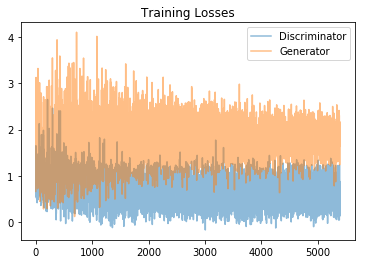

In [35]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [36]:
# Load samples from generator, taken while training
with open('train_samples64.pkl', 'rb') as f:
    samples = pkl.load(f)

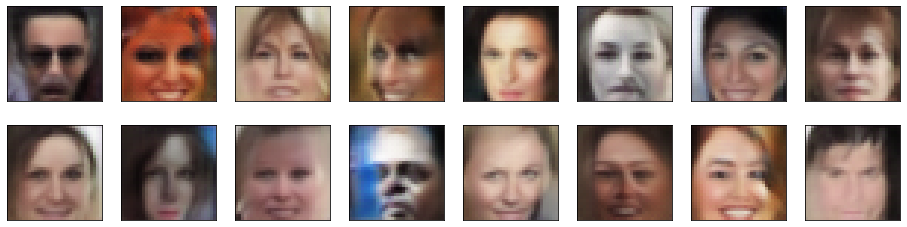

In [37]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

In this model, only white faces were considered, furthermore, few samples had facial objects (like sunglasses) which leads to some strange artifacts in the images. A more complete dataset could lead to more diverse results, but more samples with objects like sunglasses could induce further the strange artifacts in the generated faces. Maybe higher number of epochs could avoid that.

Lager models definitely increases the quality of the output model since it allows it to capture more features.

Other optimization strategies could be used, such as the decaying gradient used in the CycleGAN. There are other optimization strategies which could be explored.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.